# Data Wrangling & EDA | US Inflation

# Table of Contents<a id='#home'></a>
* [2.0 Data Wrangling](#data_w)
  * [2.1 Contents](#contents)
  * [2.2 Imports & Others](#imports)
  * [2.3 Pulling in Data](#data_pull)
  * [2.4 Initial Data Cleaning](#data_clean)
  * [2.5 Q on Q Comparison](#q_q)
    * [2.5.2 Cleaning the Q on Q Dataframe for outliers](#q_q_clean)
    * [2.5.3 Q on Q Pearson](#q_q_pearson)
  * [2.6 Monthly Comparison](#m_m)
    * [2.6.2 Cleaning the Monthly Dataframe for outliers](#m_m_clean)
    * [2.6.3 Monthly Pearson](#m_m_pearson)
  * [2.7 Quarterly Changes | Variables ( past ) & Inflation ( forwards )](#q_pf)
    * [2.7.2 Cleaning the Dataframe for outliers](#q_pf_clean)
    * [2.7.3 Quarterly Changes | Variables ( past ) & Inflation ( forwards ) | Pearson](#q_pf_pearson)
  * [2.8 Q on Q Comparison w/ Rolling Averages on Daily, Wkly & Mnthly Variables ( w/ Inflation Scraping & no variable scraping )](#rolling)
    * [2.8.2 Cleaning Q on Q Comparison w/ Rolling Averages](#rolling_clean)
    * [2.8.3 Q on Q Comparison w/ Rolling Averages Pearson](#rolling_pearson)

  * [2.3 Project Summary](#p_summary)



## **2.1 Contents**<a id='contents'></a>

The purpose of this Data Science project is to develop a model to explain & understand the phenomenon of the Consumer Price Index for All Urban Consumers in the United States ( “Inflation” ). Inflation is an important component of developing investment strategies for portfolios across the world. The view on inflation becoming positive or negative is not agreed upon nor are the variables which influence it.

In this project, I have shortlisted **nineteen** ( **19** ) **variables** to determine their influence on inflation.

The fundamental **questions to resolve in this notebook** before we move on are:
   * Are the identified variables correlated with inflation?
   * Is there enough data to build out a model?


## 2.2 Imports & Others <a id='imports'></a>

In [3]:
#Import the necessary tools required in the correct lines below
import quandl
from fredapi import Fred
from getpass import getpass
import investpy


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
import lxml
import datetime
import requests
import json
import collections
import seaborn as sns
from scipy import stats
import numpy as np
%reload_ext watermark
%watermark -d -t -v -p pandas

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.10.0

pandas: 1.2.4



In [4]:
# These will be needed later

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
today_y_m_d_dash = now.strftime("%Y-%m-%d")
today_d_m_y_dash = now.strftime("%d/%m/%Y")


In [5]:
# Importing Quandl API requires a password
# If you don't have one, please see the link below
# https://docs.quandl.com/docs#section-authentication

my_quandl_API = getpass()

········


In [6]:
quandl.ApiConfig.api_key = my_quandl_API

In [7]:
# Importing FRED API requires a password ( FRED stands for Federal Reserve Economic Data )
# If you don't have one, please see the link below
# https://fred.stlouisfed.org/docs/api/fred/

my_FRED_API = getpass()

········


In [8]:
fred = Fred(api_key=my_FRED_API)

In [9]:
# Here I am structuring a color scale for heatmaps which will be used later

cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


## 2.3 Pulling in Data<a id='data_pull'></a>

Please note, I may intend to build another USD Index based on the United States actual engagement in the world.
In other words, the USD Index used ( as of now ), is not based on the United States' trade with the world
I listed below FX pairs to possibly build out a "version" of The [USD Index Trade Weighted](https://en.wikipedia.org/wiki/Trade-weighted_US_dollar_index) but given time constraints I will work with the US Dollar Index ( not trade weighted ) for now.

While the Trade Weighted Index can be accessed by an API ( FRED ), it only goes back to 2006 
so something similar would need be created if time permits. 
My major hurdle at this time is accessing trade data & time.

   * Eurozone, Canada, Japan, Mexico, China, United Kingdom, Taiwan, South Korea, Singapore, Hong Kong, Malaysia, Brazil, Switzerland, Thailand, Philippines, Australia, Indonesia, India, Israel, Saudi Arabia, Russia, Sweden, Argentina, Venezuela, Chile & Colombia


In [10]:
# Daily Data
usd_index = quandl.get('CHRIS/ICE_DX1')
wti = quandl.get('CHRIS/CME_CL1')
copper = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
soybeans = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
natgas = investpy.get_commodity_historical_data(commodity='Natural Gas', from_date='01/01/1978', to_date=today_d_m_y_dash)
heatoil = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
corn = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
wheat = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
cattle = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
sugar = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
lumber = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
leanhogs = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
int_job_claims = quandl.get('FRED/ICSA')

# Monthly Data
cpi = quandl.get('RATEINF/INFLATION_USA')
wages_cpi = fred.get_series('CWSR0000SA0')
cap_util = fred.get_series('TCU')
unrate = quandl.get('FRED/UNRATE')
comppmi = quandl.get('ISM/MAN_PMI')

# Quarterly Data
m2_velo = fred.get_series('M2V')
gdp = fred.get_series('GDP')


In [11]:
# I chose not to not include the below for the reasons listed above their code:

# This may have altered the heatmap w/ M2 Velocity; this was less correlated   
    # us_M2 = fred.get_series('M2')              
# only goes back to 2005
    # steel = investpy.get_commodity_historical_data(commodity='US Midwest Domestic Hot-Rolled Coil Steel Futures', from_date='01/01/1978', to_date=today_d_m_y_dash)
# only goes back to 2005
    # gasoline = investpy.get_commodity_historical_data(commodity='Gasoline RBOB', from_date='01/01/1978', to_date=today_d_m_y_dash)
# only goes back to 2008  
    # oats = investpy.get_commodity_historical_data(commodity='Oats', from_date='01/01/1978', to_date=today_d_m_y_dash)
# this was removed due to amount of data
    # us_wages_hrly_earnings = fred.get_series('CES0500000003')
# poor results
    # us_wages_compensation = fred.get_series('A576RC1')


In [16]:
# As the purpose of this section is to accumulate all the data into one location to cross reference future works integrity,
# I put all here to referance ( if required ) later.

main_df = pd.concat([cpi,wages_cpi,wti['Last'],heatoil['Close'],copper['Close'],sugar['Close'],natgas['Close'],
                     cattle['Close'],leanhogs['Close'],soybeans['Close'],lumber['Close'],
                     cap_util,corn['Close'],m2_velo,gdp,wheat['Close'],comppmi['PMI'],usd_index['Settle'],
                     unrate,int_job_claims],
                    axis = 1, ignore_index=False)

main_df = main_df.fillna(method='ffill')
main_df.columns = ['Inflation','Wages CPI','WTI','Heating Oil','Copper','Sugar','Natural Gas','Cattle',
                   'Lean Hogs','Soybeans','Lumber','Capacity Utilization','Corn','M2 Velocity','GDP',
                   'Wheat','PMI','USD Index','Unemployment Rate','Initial Jobless Claims'
                  ]
main_df['Inflation'].index
main_df.index.names = ["Date"]

main_df = main_df[main_df.index.dayofweek < 5]

main_df.sort_values(by="Date", ascending=False)
main_df.tail(3)

Inflation  Wages CPI    WTI  Heating Oil  Copper  Sugar  \
Date                                                                  
2021-06-30      4.993    262.829  73.44       2.1287  4.2965  17.63   
2021-07-01      4.993    262.829  73.44       2.1562  4.2420  17.94   
2021-07-02      4.993    262.829  73.44       2.1733  4.2797  18.20   

            Natural Gas   Cattle  Lean Hogs  Soybeans  Lumber  \
Date                                                            
2021-06-30        3.650  122.500     107.47   1402.50   716.0   
2021-07-01        3.661  123.575     107.30   1394.50   735.3   
2021-07-02        3.707  121.900     107.39   1387.88   747.4   

            Capacity Utilization    Corn  M2 Velocity        GDP   Wheat  \
Date                                                                       
2021-06-30               75.2316  720.00        1.122  22061.503  678.62   
2021-07-01               75.2316  719.75        1.122  22061.503  666.50   
2021-07-02               75.2316  576.60        1.122  22061.503  651.12   

             PMI  USD Index  Unemployment Rate  Initial Jobless Claims  
Date                                                                    
2021-06-30  60.6     92.041                5.8                364000.0  
2021-07-01  60.6     92.041                5.8                364000.0  
2021-07-02  60.6     92.041                5.8                364000.0

## 2.4 Initial Data Cleaning<a id='data_clean'></a>

Here we will ensure we have homogeneous data to compare with each other.

In [18]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11538 entries, 1914-03-31 to 2021-07-02
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               11538 non-null  float64
 1   Wages CPI               11252 non-null  float64
 2   WTI                     9860 non-null   float64
 3   Heating Oil             10687 non-null  float64
 4   Copper                  8503 non-null   float64
 5   Sugar                   10687 non-null  float64
 6   Natural Gas             8070 non-null   float64
 7   Cattle                  10682 non-null  float64
 8   Lean Hogs               10687 non-null  float64
 9   Soybeans                8136 non-null   float64
 10  Lumber                  10687 non-null  float64
 11  Capacity Utilization    10908 non-null  float64
 12  Corn                    10687 non-null  float64
 13  M2 Velocity             11046 non-null  float64
 14  GDP                  

`Inflation` has by and large the most data while `Natural Gas` has the least. Let's move forward with using the `Natural Gas` amount limitations.

I will move forward with only the data where all information is present with no null values

In [19]:
main_df = main_df.loc['1990-04-04':today_y_m_d_dash]

# The reason 1990 was chosen is becuase Natural Gas only goes back that far; take a look if you wish 

In [20]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8070 entries, 1990-04-04 to 2021-07-02
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               8070 non-null   float64
 1   Wages CPI               8070 non-null   float64
 2   WTI                     8070 non-null   float64
 3   Heating Oil             8070 non-null   float64
 4   Copper                  8070 non-null   float64
 5   Sugar                   8070 non-null   float64
 6   Natural Gas             8070 non-null   float64
 7   Cattle                  8070 non-null   float64
 8   Lean Hogs               8070 non-null   float64
 9   Soybeans                8070 non-null   float64
 10  Lumber                  8070 non-null   float64
 11  Capacity Utilization    8070 non-null   float64
 12  Corn                    8070 non-null   float64
 13  M2 Velocity             8070 non-null   float64
 14  GDP                   

In [21]:
cd

C:\Users\rands


In [22]:
# Here I am saving the non-adjusted ( raw ) data to investigate whether the adjustments further along yield correctly

main_df = main_df.sort_values(by="Date", ascending=False)

main_df_csv = pd.DataFrame(main_df)
main_df_csv.to_excel('./_Capstone_One_Inflation/data/main_df_csv_w_commodities.xlsx')
print('Finished; keep going!')

Finished; keep going!


**Here we will create a summary of the variables.**

In [23]:
var_sum = main_df.T
var_sum = var_sum.index
var_sum = pd.DataFrame(var_sum)

In [24]:
reported = [ 'Monthly','Monthly','Daily','Daily','Daily','Daily','Daily','Daily','Daily','Daily',
           'Daily','Monthly','Daily','Quarterly','Quarterly','Daily','Monthly','Daily','Monthly','Weekly']
api = [ 'Quandl','FRED','Quandl','Investpy','Investpy','Investpy','Investpy','Investpy',
              'Investpy','Investpy','Investpy','FRED','Investpy','FRED','FRED',
              'Investpy','Quandl','Quandl','Quandl','Quandl']

api_source = [ 'U.S. Bureau of Labor Statistics',
            'U.S. Bureau of Labor Statistics',
            'CME',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Board of Governors of the Federal Reserve',
            'Investing.com',
            'Federal Reserve Bank of St. Louis',
            'U.S. Bureau of Economic Analysis',
            'Investing.com',
            'Institute of Supply Management',
            'Intercontinental Exchange Inc',
            'U.S. Bureau of Labor Statistics',
            'U.S. Employment and Training Administration'
             ]

comments = [ 'The target variable',
            'A component of the target variable',
            'West Texas Intermediate - One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'The % of resources used by corporations',
            'One of many commodities',
            'Movement of money; state of the economy proxy',
            'A proxy for the state of the economy',
            'One of many commodities',
            'Manufacturing PMI - A proxy for the economy',
            '( DXY ) Proxy for potentially importing inflation',
            'A proxy for the state of the economy',
            'A proxy for the state of the economy']


In [25]:
var_sum['Reported'] = reported
var_sum['API'] = api
var_sum['API Source'] = api_source
var_sum['Comments'] = comments

var_sum = var_sum.rename(columns={0:'Items', 
                                  'Reported':'Reported',
                                  'API':'API',
                                  'API Source':'API Source',
                                  'Comments':'Comments'}
                        )

In [26]:
var_sum

Items   Reported       API  \
0                Inflation    Monthly    Quandl   
1                Wages CPI    Monthly      FRED   
2                      WTI      Daily    Quandl   
3              Heating Oil      Daily  Investpy   
4                   Copper      Daily  Investpy   
5                    Sugar      Daily  Investpy   
6              Natural Gas      Daily  Investpy   
7                   Cattle      Daily  Investpy   
8                Lean Hogs      Daily  Investpy   
9                 Soybeans      Daily  Investpy   
10                  Lumber      Daily  Investpy   
11    Capacity Utilization    Monthly      FRED   
12                    Corn      Daily  Investpy   
13             M2 Velocity  Quarterly      FRED   
14                     GDP  Quarterly      FRED   
15                   Wheat      Daily  Investpy   
16                     PMI    Monthly    Quandl   
17               USD Index      Daily    Quandl   
18       Unemployment Rate    Monthly    Quandl   
19  Initial Jobless Claims     Weekly    Quandl   

                                     API Source  \
0               U.S. Bureau of Labor Statistics   
1               U.S. Bureau of Labor Statistics   
2                                           CME   
3                                 Investing.com   
4                                 Investing.com   
5                                 Investing.com   
6                                 Investing.com   
7                                 Investing.com   
8                                 Investing.com   
9                                 Investing.com   
10                                Investing.com   
11    Board of Governors of the Federal Reserve   
12                                Investing.com   
13            Federal Reserve Bank of St. Louis   
14             U.S. Bureau of Economic Analysis   
15                                Investing.com   
16               Institute of Supply Management   
17                Intercontinental Exchange Inc   
18              U.S. Bureau of Labor Statistics   
19  U.S. Employment and Training Administration   

                                             Comments  
0                                 The target variable  
1                  A component of the target variable  
2   West Texas Intermediate - One of many commodities  
3                             One of many commodities  
4                             One of many commodities  
5                             One of many commodities  
6                             One of many commodities  
7                             One of many commodities  
8                             One of many commodities  
9                             One of many commodities  
10                            One of many commodities  
11            The % of resources used by corporations  
12                            One of many commodities  
13      Movement of money; state of the economy proxy  
14               A proxy for the state of the economy  
15                            One of many commodities  
16        Manufacturing PMI - A proxy for the economy  
17  ( DXY ) Proxy for potentially importing inflation  
18               A proxy for the state of the economy  
19               A proxy for the state of the economy

## 2.5 Q on Q Comparison<a id='q_q'></a>

In 2.5 I will be setting up the infrastructure for **comparing quarterly changes on all variables** against a **quarterly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [27]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi = cpi.diff(periods=3)
Q_unrate = unrate.diff(periods=3)
Q_comppmi = comppmi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)


In [28]:
# ( Complete ) The above were slow reviewed & they all align with the forward fill modus operandi 

QonQ_vars = pd.concat([Q_wages,Q_wti,Q_heatoil,Q_copper,Q_sugar,
                     Q_natgas,Q_cattle,Q_leanhogs,Q_soybeans,Q_lumber,
                     Q_caputil,Q_corn,Q_m2_velo,Q_gdp,Q_wheat,Q_comppmi,
                      Q_usd_index,Q_unrate,Q_intjobs],
                      axis = 1, ignore_index=False)

QonQ_vars = QonQ_vars.fillna(method='ffill')
QonQ_vars.columns = ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_vars.dropna(how='any')
QonQ_vars.index.names = ["Date"]

QonQ_vars = QonQ_vars[QonQ_vars.index.dayofweek < 5]

QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=True)

In [29]:
# Determining the null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10969 entries, 1946-01-01 to 2021-07-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                10964 non-null  float64
 1   WTI                     9790 non-null   float64
 2   Heating Oil             10615 non-null  float64
 3   Copper                  8434 non-null   float64
 4   Sugar                   10615 non-null  float64
 5   Natural Gas             7998 non-null   float64
 6   Cattle                  10612 non-null  float64
 7   Lean Hogs               10616 non-null  float64
 8   Soybeans                8067 non-null   float64
 9   Lumber                  10616 non-null  float64
 10  Capacity Utilization    10791 non-null  float64
 11  Corn                    10614 non-null  float64
 12  M2 Velocity             10862 non-null  float64
 13  GDP                     10964 non-null  float64
 14  Wheat                

In [30]:
# As previously mentioned, Natural Gas limits this Dataframe
# Thus, the reason 1990-07-10 was chosen is becuase Natural Gas only goes back that far 

QonQ_vars = QonQ_vars.loc['1990-07-10':today_y_m_d_dash]

In [31]:
# Double confirming no null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7998 entries, 1990-07-10 to 2021-07-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                7998 non-null   float64
 1   WTI                     7998 non-null   float64
 2   Heating Oil             7998 non-null   float64
 3   Copper                  7998 non-null   float64
 4   Sugar                   7998 non-null   float64
 5   Natural Gas             7998 non-null   float64
 6   Cattle                  7998 non-null   float64
 7   Lean Hogs               7998 non-null   float64
 8   Soybeans                7998 non-null   float64
 9   Lumber                  7998 non-null   float64
 10  Capacity Utilization    7998 non-null   float64
 11  Corn                    7998 non-null   float64
 12  M2 Velocity             7998 non-null   float64
 13  GDP                     7998 non-null   float64
 14  Wheat                 

Saving the Variables for later use to confirm rolling averages.

In [32]:
QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=False)
QonQ_vars_csv = pd.DataFrame(QonQ_vars)

QonQ_vars_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_vars.xlsx')
print('Finished; keep going!')

Finished; keep going!


Now that the variables are in place, I will pull `Inflation` in with them via a merge to ensure the variables are working off the `Inflation` set. 

In [33]:
QonQ_main = Q_cpi.merge(QonQ_vars, how='left', on='Date')

# QonQ_forward.loc[:,cols_forward] = QonQ.loc[:,cols_forward].ffill()
QonQ_main.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_main = QonQ_main.dropna()

In [34]:
QonQ_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 1990-07-31 to 2021-05-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               262 non-null    float64
 1   Wage CPI                262 non-null    float64
 2   WTI                     262 non-null    float64
 3   Heating Oil             262 non-null    float64
 4   Copper                  262 non-null    float64
 5   Sugar                   262 non-null    float64
 6   Natural Gas             262 non-null    float64
 7   Cattle                  262 non-null    float64
 8   Lean Hogs               262 non-null    float64
 9   Soybeans                262 non-null    float64
 10  Lumber                  262 non-null    float64
 11  Capacity Utilization    262 non-null    float64
 12  Corn                    262 non-null    float64
 13  M2 Velocity             262 non-null    float64
 14  GDP                    

## 2.5.2 Cleaning the Q on Q Dataframe for outliers<a id='q_q_clean'></a>

Here I begin to determine where outliers are:

In [35]:
QonQ_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.730923  0.342741     0.423581  0.243814   
Wage CPI                 0.730923  1.000000  0.410436     0.503562  0.339808   
WTI                      0.342741  0.410436  1.000000     0.802004  0.429679   
Heating Oil              0.423581  0.503562  0.802004     1.000000  0.421138   
Copper                   0.243814  0.339808  0.429679     0.421138  1.000000   
Sugar                    0.142794  0.183833  0.181075     0.168583  0.253122   
Natural Gas              0.287962  0.303431  0.251209     0.413742  0.087285   
Cattle                   0.152737  0.195233  0.156249     0.150980  0.115840   
Lean Hogs                0.236803  0.157045  0.138665     0.105843  0.169547   
Soybeans                 0.075573  0.143665  0.154394     0.173419  0.211788   
Lumber                   0.183078  0.135533  0.283766     0.149405  0.223952   
Capacity Utilization     0.292533  0.254050  0.438066     0.374163  0.237046   
Corn                     0.121441  0.098422  0.044106     0.062063  0.124394   
M2 Velocity              0.228701  0.290532  0.177540     0.232521  0.127958   
GDP                      0.288607  0.301026  0.296728     0.256627  0.158630   
Wheat                   -0.021089  0.004462 -0.012125     0.003022  0.086442   
PMI                      0.142786  0.234592  0.397598     0.332077  0.464940   
USD Index               -0.205247 -0.286428 -0.268375    -0.307142 -0.346286   
Unemployment Rate       -0.248629 -0.232775 -0.261297    -0.252517 -0.089613   
Initial Jobless Claims  -0.101996 -0.095053 -0.430095    -0.276281 -0.173347   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.142794     0.287962  0.152737   0.236803  0.075573   
Wage CPI                0.183833     0.303431  0.195233   0.157045  0.143665   
WTI                     0.181075     0.251209  0.156249   0.138665  0.154394   
Heating Oil             0.168583     0.413742  0.150980   0.105843  0.173419   
Copper                  0.253122     0.087285  0.115840   0.169547  0.211788   
Sugar                   1.000000     0.151016  0.028306  -0.081495  0.136902   
Natural Gas             0.151016     1.000000  0.014112   0.028114  0.059871   
Cattle                  0.028306     0.014112  1.000000   0.171485  0.087982   
Lean Hogs              -0.081495     0.028114  0.171485   1.000000  0.213879   
Soybeans                0.136902     0.059871  0.087982   0.213879  1.000000   
Lumber                  0.088719    -0.063740  0.186457   0.209007  0.205290   
Capacity Utilization    0.171072     0.122411  0.293579   0.157413  0.138334   
Corn                    0.079064     0.078809  0.030021   0.264713  0.706273   
M2 Velocity             0.109746     0.087264  0.203940   0.106590  0.036682   
GDP                     0.127007     0.103493  0.246943   0.183535  0.061077   
Wheat                   0.087762     0.012672  0.010299   0.040972  0.435542   
PMI                     0.150550     0.035040  0.186336   0.118813  0.148822   
USD Index              -0.139898    -0.240458 -0.049255   0.042533 -0.142864   
Unemployment Rate      -0.119057    -0.065578 -0.286034  -0.134661 -0.068358   
Initial Jobless Claims -0.128448    -0.054532 -0.174698  -0.059571 -0.057225   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.183078              0.292533  0.121441     0.228701   
Wage CPI                0.135533              0.254050  0.098422     0.290532   
WTI                     0.283766              0.438066  0.044106     0.177540   
Heating Oil             0.149405              0.374163  0.062063     0.232521   
Copper                  0.223952              0.237046  0.124394     0.127958   
Sugar                   0.088719              0.171072  0.079064     0.109746   
Natural Gas            -0.063740              0.122411  0.078809     0.087264   
Cattle        

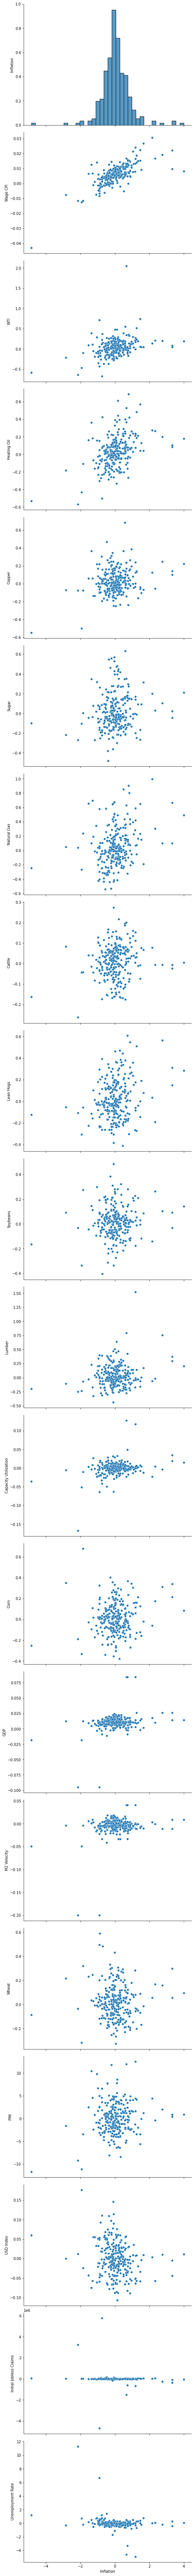

In [36]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

We can see a **notable amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram.

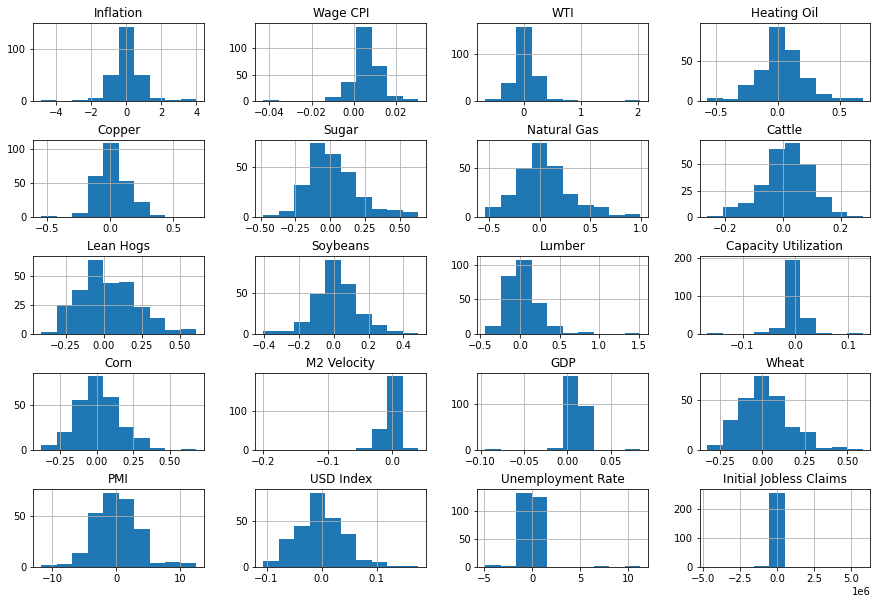

In [37]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

Text(0, 0.5, 'Count')

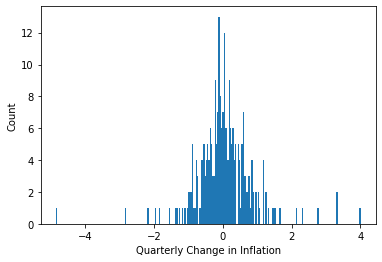

In [38]:
plt.hist(QonQ_main['Inflation'], bins=240)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

It may appear that we scrape anything ± 300 bps

In [39]:
cpi_comp = np.abs(stats.zscore(QonQ_main['Inflation']))
threshold = 3
print(np.where( cpi_comp > threshold ))

(array([137, 156, 163, 164, 260, 261], dtype=int64),)


In [40]:
QonQ_main['Inflation'][137], QonQ_main['Inflation'][156], QonQ_main['Inflation'][163],QonQ_main['Inflation'][164]

(-2.84, -4.846, 3.322, 4.007)

We will pull ~3 off ( -4.846, 3.322, 4.007 )

In [41]:
droprows = [156, 163, 164]
QonQ_main.drop(QonQ_main.index[droprows], inplace=True)

Text(0, 0.5, 'Count')

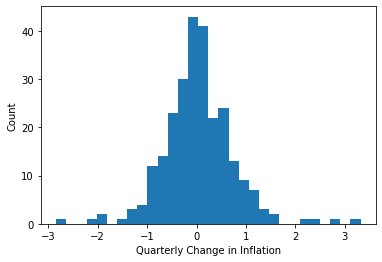

In [42]:
plt.hist(QonQ_main['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

After removing the outliers of Inflation, let's see how the pair plots & histograms hold up.

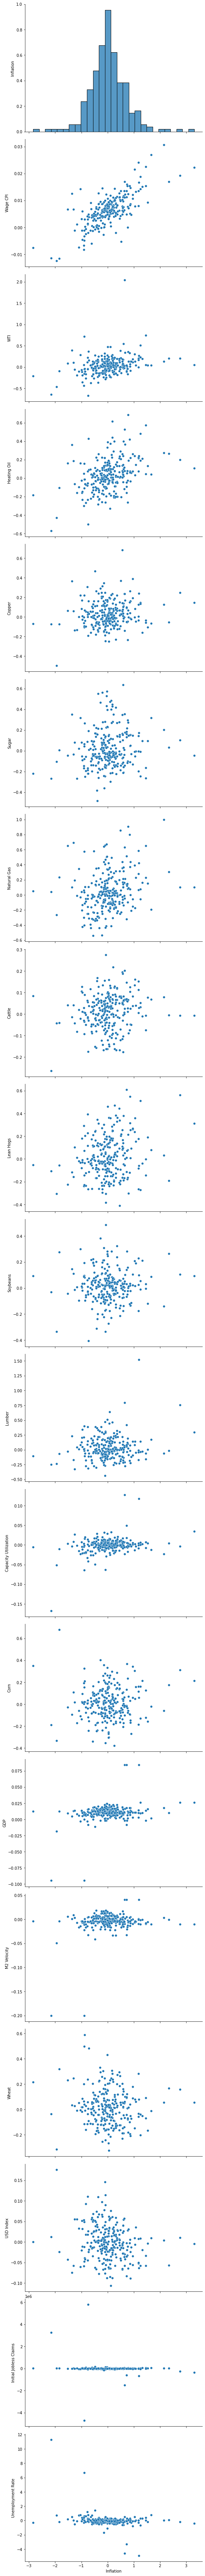

In [43]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

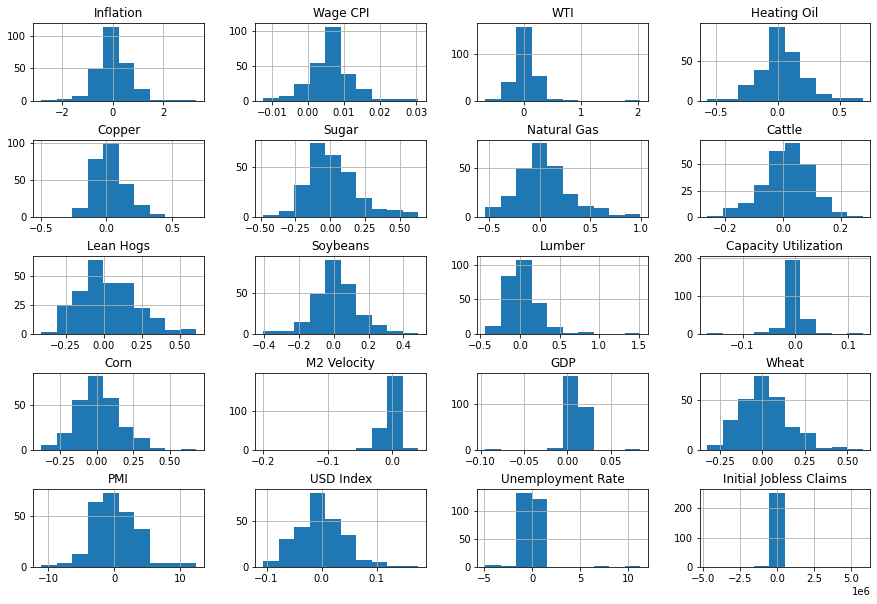

In [44]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

In [45]:
QonQ_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.730626  0.316873     0.400562  0.142106   
Wage CPI                 0.730626  1.000000  0.378259     0.474925  0.255281   
WTI                      0.316873  0.378259  1.000000     0.794904  0.402831   
Heating Oil              0.400562  0.474925  0.794904     1.000000  0.388379   
Copper                   0.142106  0.255281  0.402831     0.388379  1.000000   
Sugar                    0.128367  0.185974  0.174717     0.161217  0.247154   
Natural Gas              0.236358  0.305101  0.241404     0.408133  0.058759   
Cattle                   0.134142  0.153540  0.137450     0.129783  0.087197   
Lean Hogs                0.216160  0.148542  0.128603     0.093248  0.154189   
Soybeans                 0.035368  0.114913  0.139511     0.157151  0.192105   
Lumber                   0.139820  0.112620  0.275078     0.135227  0.207692   
Capacity Utilization     0.268511  0.229480  0.427284     0.360253  0.213297   
Corn                     0.048014  0.049154  0.023130     0.038165  0.094138   
M2 Velocity              0.189232  0.256826  0.156018     0.209716  0.092505   
GDP                      0.275783  0.271683  0.279899     0.236557  0.128423   
Wheat                   -0.091133 -0.023649 -0.023262    -0.009876  0.071307   
PMI                      0.072914  0.160089  0.375429     0.303773  0.436077   
USD Index               -0.193873 -0.278171 -0.259044    -0.297889 -0.338378   
Unemployment Rate       -0.268959 -0.224912 -0.253591    -0.244249 -0.074425   
Initial Jobless Claims  -0.111733 -0.103965 -0.435606    -0.280395 -0.177665   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.128367     0.236358  0.134142   0.216160  0.035368   
Wage CPI                0.185974     0.305101  0.153540   0.148542  0.114913   
WTI                     0.174717     0.241404  0.137450   0.128603  0.139511   
Heating Oil             0.161217     0.408133  0.129783   0.093248  0.157151   
Copper                  0.247154     0.058759  0.087197   0.154189  0.192105   
Sugar                   1.000000     0.144407  0.023676  -0.090049  0.130362   
Natural Gas             0.144407     1.000000  0.009697   0.009800  0.051735   
Cattle                  0.023676     0.009697  1.000000   0.168944  0.076863   
Lean Hogs              -0.090049     0.009800  0.168944   1.000000  0.207342   
Soybeans                0.130362     0.051735  0.076863   0.207342  1.000000   
Lumber                  0.083455    -0.091014  0.183489   0.199710  0.201151   
Capacity Utilization    0.165670     0.104865  0.286119   0.147796  0.128981   
Corn                    0.074007     0.050376  0.019859   0.256450  0.713354   
M2 Velocity             0.103223     0.070721  0.190712   0.096516  0.023126   
GDP                     0.122158     0.093193  0.233985   0.177562  0.049106   
Wheat                   0.084712    -0.011794  0.008023   0.031169  0.439041   
PMI                     0.144875     0.017928  0.164708   0.109510  0.133314   
USD Index              -0.138717    -0.232935 -0.039974   0.048591 -0.139248   
Unemployment Rate      -0.117193    -0.065266 -0.278858  -0.133441 -0.062037   
Initial Jobless Claims -0.128067    -0.052767 -0.175903  -0.058491 -0.056805   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.139820              0.268511  0.048014     0.189232   
Wage CPI                0.112620              0.229480  0.049154     0.256826   
WTI                     0.275078              0.427284  0.023130     0.156018   
Heating Oil             0.135227              0.360253  0.038165     0.209716   
Copper                  0.207692              0.213297  0.094138     0.092505   
Sugar                   0.083455              0.165670  0.074007     0.103223   
Natural Gas            -0.091014              0.104865  0.050376     0.070721   
Cattle        

{'whiskers': [<matplotlib.lines.Line2D at 0x124e6a80460>,
 'caps': [<matplotlib.lines.Line2D at 0x124e6a80b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x124e6a80160>],
 'medians': [<matplotlib.lines.Line2D at 0x124e6a8c220>],
 'fliers': [<matplotlib.lines.Line2D at 0x124e6a8c580>],
 'means': []}

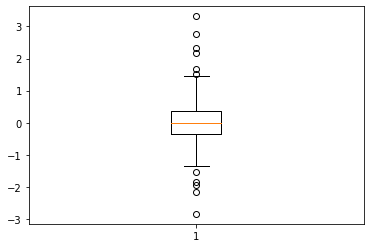

In [46]:
plt.boxplot(QonQ_main['Inflation'])

### 2.5.3 Q on Q Pearson<a id='q_q_pearson'></a>

Text(0.5, 1.0, 'Quarter on Quarter Comparison')

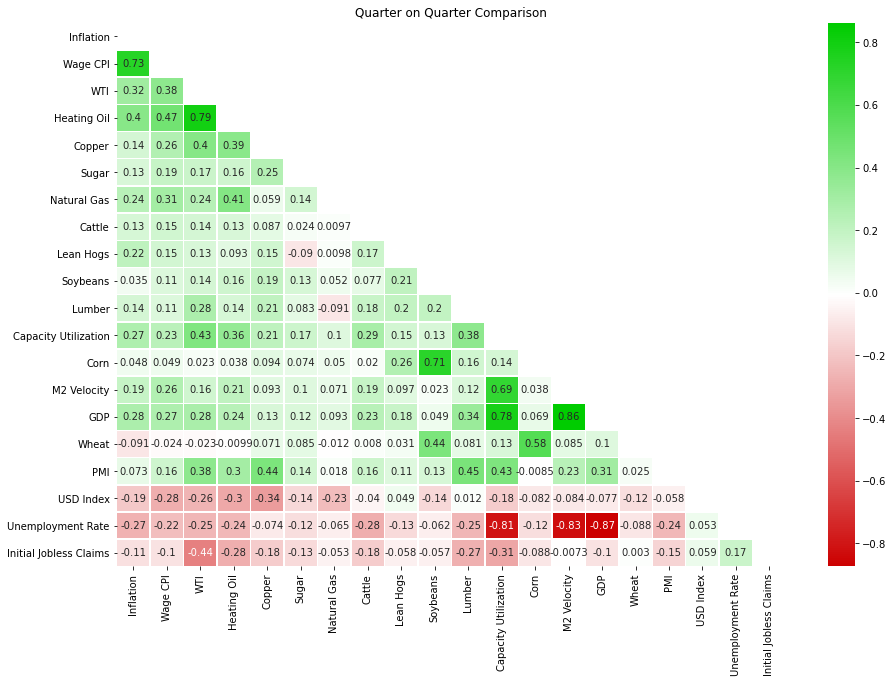

In [48]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main.corr())
sns.heatmap(QonQ_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison')

In [168]:
# looking at the average pearson coefficient
q_q_main = QonQ_main.corr(method='pearson')
q_q_main = pd.DataFrame(q_q_main['Inflation'])
q_q_main = q_q_main.iloc[1: , :]
q_q_main['AbsAmount'] = q_q_main['Inflation'].abs()
q_q_main = q_q_main['AbsAmount'].mean()


In [49]:
QonQ_main = QonQ_main.sort_values(by="Date", ascending=True)
QonQ_main_csv = pd.DataFrame(QonQ_main)

QonQ_main_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main.xlsx')
print('Finished')

Finished


## 2.6 Monthly Comparison<a id='m_m'></a>

In 2.6 I will be setting up the infrastructure for **comparing monthly changes on all variables** against a **monthly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [51]:
# ( Complete ) Daily | USD & WTI 
M_usd_index = usd_index['Settle'].pct_change(periods=30)
M_wti = wti['Last'].pct_change(periods=30)
M_copper = copper['Close'].pct_change(periods=30)
M_soybeans = soybeans['Close'].pct_change(periods=30)
M_natgas = natgas['Close'].pct_change(periods=30)
M_heatoil = heatoil['Close'].pct_change(periods=30)
M_corn = corn['Close'].pct_change(periods=30)
M_wheat = wheat['Close'].pct_change(periods=30)
M_cattle = cattle['Close'].pct_change(periods=30)
M_sugar = sugar['Close'].pct_change(periods=30)
M_lumber = lumber['Close'].pct_change(periods=30)
M_leanhogs = leanhogs['Close'].pct_change(periods=30)

# ( Complete ) Weekly | Initial Jobless Claims
M_intjobs = int_job_claims.diff(periods=4)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
M_caputil = cap_util.pct_change(periods=1)
M_wages = wages_cpi.pct_change(periods=1)
M_cpi = cpi.diff(periods=1)
M_unrate = unrate.diff(periods=1)
M_pmi = comppmi.diff(periods=3)


# ( Complete ) Quarterly | GDP, Velocity of Money
# M_gdp = us_gdp.pct_change(periods=1)
# M_m2_velo = m2_velo.pct_change(periods=1)

In [52]:
# Building out the variables first with a forward fill
MonM_vars = pd.concat([M_wages,M_wti,M_heatoil,M_copper,M_sugar,M_natgas,
                       M_cattle,M_leanhogs,M_soybeans,M_lumber,M_caputil,M_corn,
                       M_wheat,M_pmi,M_usd_index,M_unrate,M_intjobs],
                      axis = 1, ignore_index=False)

MonM_vars.columns= ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'
                   ]

MonM_vars.index.names = ["Date"]
MonM_vars = MonM_vars.fillna(method='ffill')

# vars_mnth.tail()

In [53]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14236 entries, 1947-01-01 to 2021-07-02
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                14235 non-null  float64
 1   WTI                     12148 non-null  float64
 2   Heating Oil             13148 non-null  float64
 3   Copper                  10503 non-null  float64
 4   Sugar                   13150 non-null  float64
 5   Natural Gas             9979 non-null   float64
 6   Cattle                  13145 non-null  float64
 7   Lean Hogs               13150 non-null  float64
 8   Soybeans                10060 non-null  float64
 9   Lumber                  13150 non-null  float64
 10  Capacity Utilization    13991 non-null  float64
 11  Corn                    13147 non-null  float64
 12  Wheat                   10060 non-null  float64
 13  PMI                     14221 non-null  float64
 14  USD Index            

In [54]:
# As before, working backwards off of Natural Gas to bring the data together
# MonM_vars['Natural Gas'].tail(8302)

MonM_vars = MonM_vars.loc['1990-05-17':today_y_m_d_dash]

In [55]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9979 entries, 1990-05-17 to 2021-07-02
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                9979 non-null   float64
 1   WTI                     9979 non-null   float64
 2   Heating Oil             9979 non-null   float64
 3   Copper                  9979 non-null   float64
 4   Sugar                   9979 non-null   float64
 5   Natural Gas             9979 non-null   float64
 6   Cattle                  9979 non-null   float64
 7   Lean Hogs               9979 non-null   float64
 8   Soybeans                9979 non-null   float64
 9   Lumber                  9979 non-null   float64
 10  Capacity Utilization    9979 non-null   float64
 11  Corn                    9979 non-null   float64
 12  Wheat                   9979 non-null   float64
 13  PMI                     9979 non-null   float64
 14  USD Index             

In [56]:
# Putting them together with inflation
MonM_main = M_cpi.merge(MonM_vars, how='left', on='Date')

MonM_main = MonM_main[MonM_main.index.dayofweek < 5]

MonM_main.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                    'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber','Capacity Utilization',
                    'Corn','Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'
                    ]

MonM_main = MonM_main.dropna()

In [57]:
MonM_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263 entries, 1990-05-31 to 2021-05-31
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               263 non-null    float64
 1   Wage CPI                263 non-null    float64
 2   WTI                     263 non-null    float64
 3   Heating Oil             263 non-null    float64
 4   Copper                  263 non-null    float64
 5   Sugar                   263 non-null    float64
 6   Natural Gas             263 non-null    float64
 7   Cattle                  263 non-null    float64
 8   Lean Hogs               263 non-null    float64
 9   Soybeans                263 non-null    float64
 10  Lumber                  263 non-null    float64
 11  Capacity Utilization    263 non-null    float64
 12  Corn                    263 non-null    float64
 13  Wheat                   263 non-null    float64
 14  PMI                    

## 2.6.2 Cleaning the Monthly Dataframe for outliers<a id='m_m_clean'></a>

Here I begin to determine where outliers are:

In [58]:
MonM_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.720756  0.282635     0.300308  0.138205   
Wage CPI                 0.720756  1.000000  0.360299     0.383895  0.218995   
WTI                      0.282635  0.360299  1.000000     0.828168  0.384437   
Heating Oil              0.300308  0.383895  0.828168     1.000000  0.344271   
Copper                   0.138205  0.218995  0.384437     0.344271  1.000000   
Sugar                    0.142368  0.138112  0.114847     0.107308  0.199506   
Natural Gas              0.141496  0.147765  0.232350     0.319993  0.007656   
Cattle                   0.017416  0.074284  0.081847     0.072803  0.121768   
Lean Hogs                0.089083  0.031402  0.067323     0.025522  0.158970   
Soybeans                 0.096572  0.091271  0.124456     0.140240  0.245081   
Lumber                   0.249326  0.181791  0.159909     0.099460  0.200431   
Capacity Utilization     0.261658  0.244313  0.196644     0.216297  0.085609   
Corn                     0.112929  0.031093  0.056770     0.068236  0.113093   
Wheat                   -0.029462 -0.007024 -0.032516     0.025408  0.057574   
PMI                      0.183484  0.248742  0.231903     0.240785  0.352891   
USD Index               -0.100881 -0.166584 -0.267601    -0.188474 -0.267325   
Initial Jobless Claims  -0.253738 -0.251209 -0.137692    -0.170223 -0.013559   
Unemployment Rate       -0.051108 -0.027439 -0.258601    -0.143725 -0.138119   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.142368     0.141496  0.017416   0.089083  0.096572   
Wage CPI                0.138112     0.147765  0.074284   0.031402  0.091271   
WTI                     0.114847     0.232350  0.081847   0.067323  0.124456   
Heating Oil             0.107308     0.319993  0.072803   0.025522  0.140240   
Copper                  0.199506     0.007656  0.121768   0.158970  0.245081   
Sugar                   1.000000     0.087219  0.071522  -0.039588  0.158675   
Natural Gas             0.087219     1.000000 -0.057066   0.062957  0.052185   
Cattle                  0.071522    -0.057066  1.000000   0.177257  0.090783   
Lean Hogs              -0.039588     0.062957  0.177257   1.000000  0.169558   
Soybeans                0.158675     0.052185  0.090783   0.169558  1.000000   
Lumber                  0.044193    -0.028162  0.126474   0.088450  0.165676   
Capacity Utilization    0.083501    -0.018117  0.104341   0.033673  0.073888   
Corn                    0.107981     0.078183 -0.038208   0.147583  0.666345   
Wheat                   0.106092     0.030197  0.030584   0.033761  0.425540   
PMI                     0.080317     0.069306  0.112842   0.040301  0.089981   
USD Index              -0.087187    -0.137408 -0.019345   0.018054 -0.142730   
Initial Jobless Claims -0.040909     0.021925 -0.068028  -0.036827 -0.067459   
Unemployment Rate      -0.161855    -0.081608 -0.137851  -0.095214  0.003167   

                          Lumber  Capacity Utilization      Corn     Wheat  \
Inflation               0.249326              0.261658  0.112929 -0.029462   
Wage CPI                0.181791              0.244313  0.031093 -0.007024   
WTI                     0.159909              0.196644  0.056770 -0.032516   
Heating Oil             0.099460              0.216297  0.068236  0.025408   
Copper                  0.200431              0.085609  0.113093  0.057574   
Sugar                   0.044193              0.083501  0.107981  0.106092   
Natural Gas            -0.028162             -0.018117  0.078183  0.030197   
Cattle                  0.126474              0.104341 -0.038208  0.030584   
Lean Hogs               0.088450              0.033673  0.147583  0.033761   
Soybeans                0.165676              0.073888  0.666345  0.425540   
Lumber                  1.000000              0.190226  0.154484  0.102117   
Capacity Utilization    0.190226              

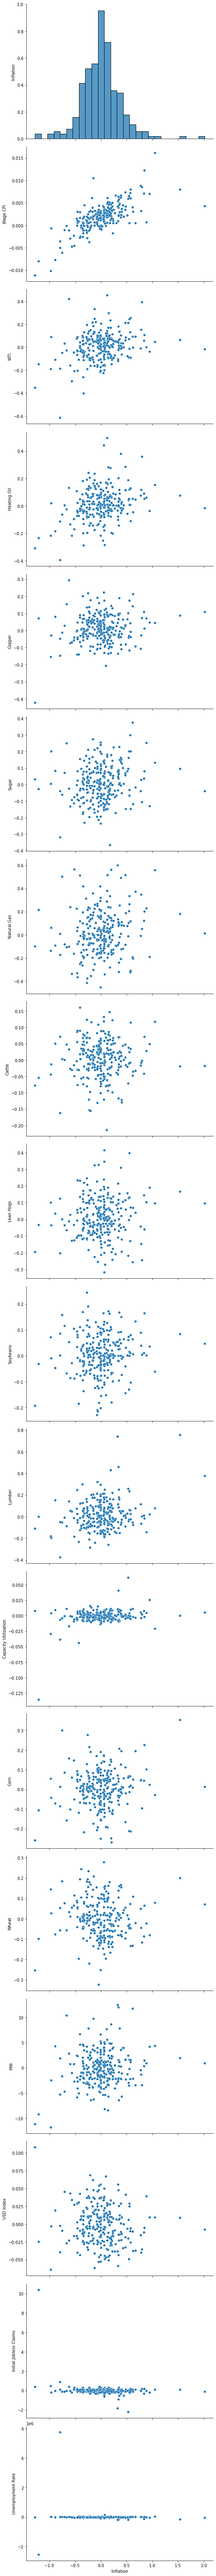

In [59]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                    'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber','Capacity Utilization',
                    'Corn','Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

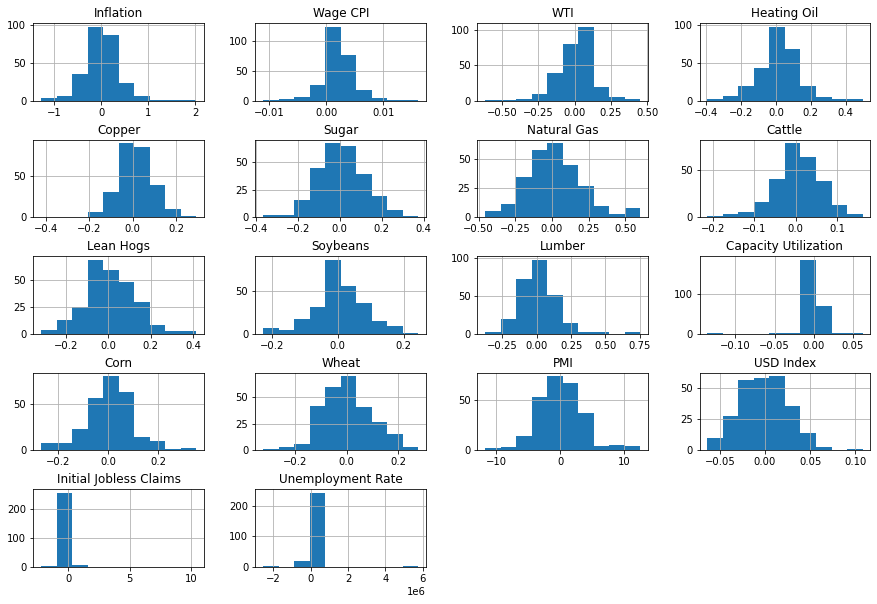

In [60]:
MonM_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

We see **"some" amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram again.

Text(0, 0.5, 'Count')

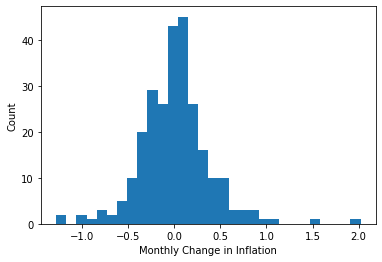

In [61]:
plt.hist(MonM_main['Inflation'], bins=30)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Count')

**There doesn't seem to be as much variation here as well.** Let's take a look at what those numbers are.

In [62]:
print('Min # is:', MonM_main['Inflation'].min(), 'Max # is:', MonM_main['Inflation'].max())

Min # is: -1.2820000000000005 Max # is: 2.021


Based on this, I will choose to remove the data point ~2

In [63]:
cpi_check = np.abs(stats.zscore(MonM_main['Inflation']))
threshold = 3
print(np.where(cpi_check > threshold))

(array([156, 164, 253, 261], dtype=int64),)


In [64]:
MonM_main['Inflation'][156],MonM_main['Inflation'][164],MonM_main['Inflation'][253]

(-1.2820000000000005, 2.021, -1.21)

In [65]:
droprow = [164]
MonM_main.drop(MonM_main.index[droprow], inplace=True)

Checking the pair plots & histogram once more.

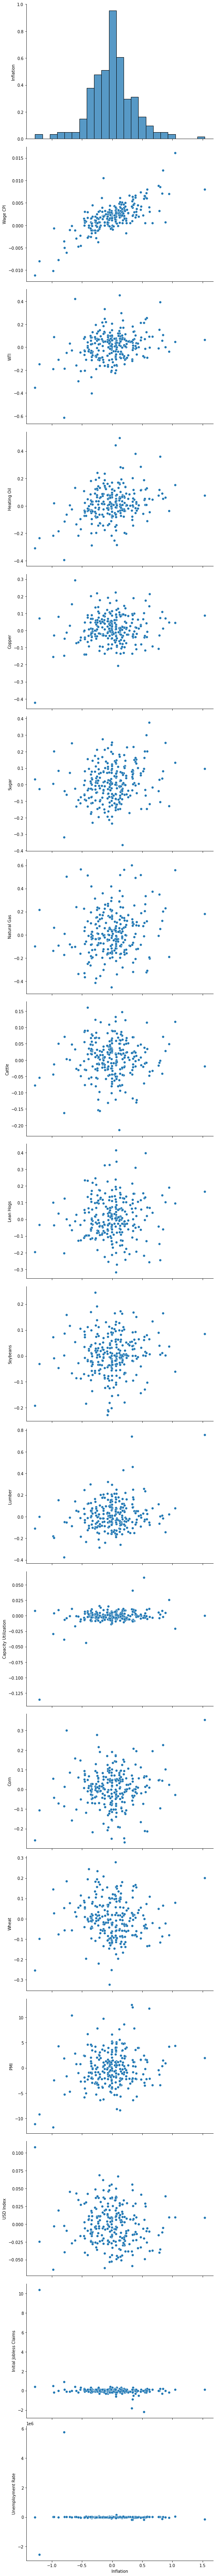

In [66]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                    'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber','Capacity Utilization',
                    'Corn','Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

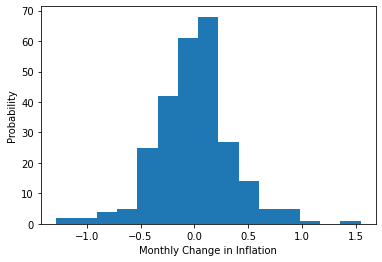

In [67]:
plt.hist(MonM_main['Inflation'], bins=15)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Probability')

Not perfectly normal but we will proceed.

In [68]:
MonM_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.746449  0.303754     0.323640  0.121154   
Wage CPI                 0.746449  1.000000  0.361439     0.385251  0.216255   
WTI                      0.303754  0.361439  1.000000     0.828132  0.386544   
Heating Oil              0.323640  0.385251  0.828132     1.000000  0.346535   
Copper                   0.121154  0.216255  0.386544     0.346535  1.000000   
Sugar                    0.159725  0.139610  0.114531     0.106905  0.202066   
Natural Gas              0.150597  0.148073  0.232336     0.319995  0.007878   
Cattle                   0.026686  0.075562  0.081545     0.072420  0.123903   
Lean Hogs                0.079048  0.029310  0.068011     0.026317  0.156290   
Soybeans                 0.090509  0.089778  0.125011     0.140929  0.243384   
Lumber                   0.210461  0.176429  0.164374     0.103671  0.191524   
Capacity Utilization     0.266008  0.243186  0.197200     0.216984  0.083554   
Corn                     0.117755  0.030891  0.056844     0.068331  0.113040   
Wheat                   -0.047089 -0.009288 -0.031913     0.026237  0.054388   
PMI                      0.188840  0.248323  0.232164     0.241113  0.352767   
USD Index               -0.101625 -0.166080 -0.267861    -0.188778 -0.266991   
Initial Jobless Claims  -0.264851 -0.251020 -0.137855    -0.170435 -0.012839   
Unemployment Rate       -0.051077 -0.027051 -0.258755    -0.143901 -0.137861   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.159725     0.150597  0.026686   0.079048  0.090509   
Wage CPI                0.139610     0.148073  0.075562   0.029310  0.089778   
WTI                     0.114531     0.232336  0.081545   0.068011  0.125011   
Heating Oil             0.106905     0.319995  0.072420   0.026317  0.140929   
Copper                  0.202066     0.007878  0.123903   0.156290  0.243384   
Sugar                   1.000000     0.087178  0.070935  -0.038471  0.159717   
Natural Gas             0.087178     1.000000 -0.057147   0.063139  0.052308   
Cattle                  0.070935    -0.057147  1.000000   0.178544  0.091675   
Lean Hogs              -0.038471     0.063139  0.178544   1.000000  0.168318   
Soybeans                0.159717     0.052308  0.091675   0.168318  1.000000   
Lumber                  0.049157    -0.028094  0.132171   0.082426  0.162414   
Capacity Utilization    0.084405    -0.018040  0.105180   0.032323  0.072895   
Corn                    0.108149     0.078198 -0.038102   0.147513  0.666570   
Wheat                   0.107460     0.030355  0.031731   0.031786  0.424672   
PMI                     0.080757     0.069356  0.113253   0.039670  0.089526   
USD Index              -0.087617    -0.137464 -0.019706   0.018728 -0.142326   
Initial Jobless Claims -0.041196     0.021899 -0.068297  -0.036410 -0.067152   
Unemployment Rate      -0.162146    -0.081635 -0.138103  -0.094928  0.003463   

                          Lumber  Capacity Utilization      Corn     Wheat  \
Inflation               0.210461              0.266008  0.117755 -0.047089   
Wage CPI                0.176429              0.243186  0.030891 -0.009288   
WTI                     0.164374              0.197200  0.056844 -0.031913   
Heating Oil             0.103671              0.216984  0.068331  0.026237   
Copper                  0.191524              0.083554  0.113040  0.054388   
Sugar                   0.049157              0.084405  0.108149  0.107460   
Natural Gas            -0.028094             -0.018040  0.078198  0.030355   
Cattle                  0.132171              0.105180 -0.038102  0.031731   
Lean Hogs               0.082426              0.032323  0.147513  0.031786   
Soybeans                0.162414              0.072895  0.666570  0.424672   
Lumber                  1.000000              0.187683  0.155763  0.095999   
Capacity Utilization    0.187683              

{'whiskers': [<matplotlib.lines.Line2D at 0x124e967fdc0>,
 'caps': [<matplotlib.lines.Line2D at 0x124e967f940>,
 'boxes': [<matplotlib.lines.Line2D at 0x124e967fb20>],
 'medians': [<matplotlib.lines.Line2D at 0x124e724dee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x124e9576070>],
 'means': []}

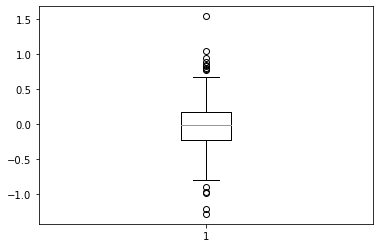

In [69]:
plt.boxplot(MonM_main['Inflation'])

## 2.6.3 Monthly Pearson<a id='m_m_pearson'></a>

Text(0.5, 1.0, 'Month on Month Comparison')

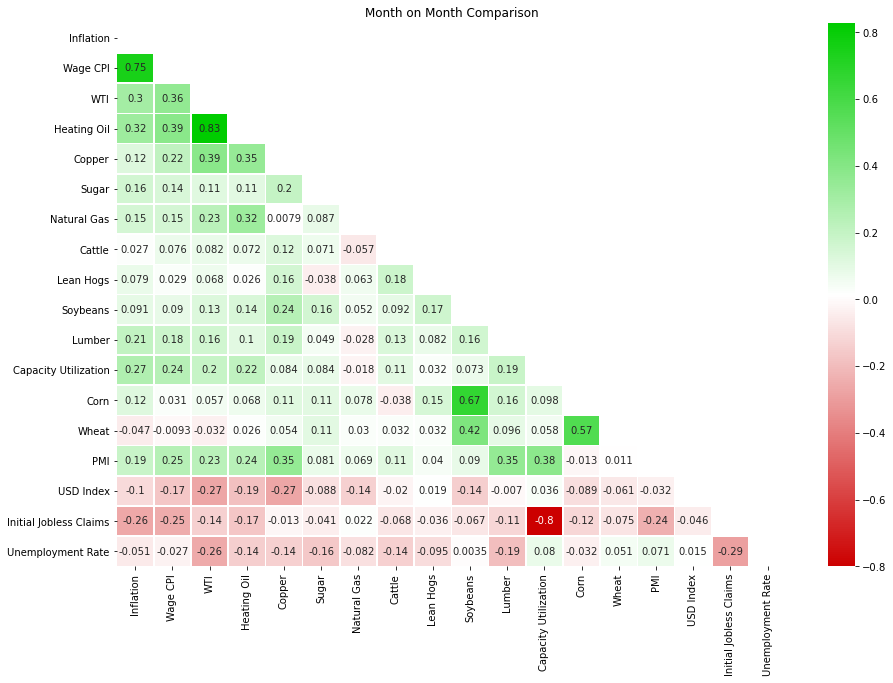

In [70]:
plt.subplots(figsize=(15,10))
matrix = np.triu(MonM_main.corr())
sns.heatmap(MonM_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Month on Month Comparison')

In [169]:
# looking at the average pearson coefficient
m_m_main = MonM_main.corr(method='pearson')
m_m_main = pd.DataFrame(m_m_main['Inflation'])
m_m_main = m_m_main.iloc[1: , :]
m_m_main['AbsAmount'] = m_m_main['Inflation'].abs()
m_m_main = m_m_main['AbsAmount'].mean()


In [71]:
MonM_main = MonM_main.sort_values(by="Date", ascending=True)
MonM_main_csv = pd.DataFrame(MonM_main)

MonM_main_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/MonM_main.xlsx')
print('Finished')

Finished


## 2.7 Quarterly Changes | Variables ( past ) & Inflation ( forwards )<a id='q_pf'></a>

In 2.7 I will be setting up the infrastructure to **compare quarterly changes on all variables ( one quarter in the past )** against a **quarterly change in inflation ( one quarter in the future )** to ascertain if there's any relationship to **predict** `Inflation` one quarter in advance.  

In [72]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi_past = cpi.diff(periods=-3)
Q_unrate = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

Checking to see if the `Inflation` function works as I intend 

In [73]:
# To compare what the function is returning
Q_cpi_past.tail(5)

Value
Date             
2021-01-31 -2.760
2021-02-28 -3.317
2021-03-31    NaN
2021-04-30    NaN
2021-05-31    NaN

In [74]:
# I start with the actual data
cpi.tail(10)

Value
Date             
2020-08-31  1.310
2020-09-30  1.371
2020-10-31  1.182
2020-11-30  1.175
2020-12-31  1.362
2021-01-31  1.400
2021-02-28  1.676
2021-03-31  2.620
2021-04-30  4.160
2021-05-31  4.993

In [76]:
print('The 31 May 2021 # of 4.993 minus 3 months before ( 2021-02-28 ) show: ', round((4.993-1.676),3) )

The 31 May 2021 # of 4.993 minus 3 months before ( 2021-02-28 ) show:  3.317


This **appears to be incorrect,** meaning it should be a positive number but shows a negative number in the `Q_cpi_p` tail. **Let's check the one behind to see what that shows.**

In [77]:
print('The 30 Apr 2021 # of 4.160 minus 3 months before ( 31 Jan 2021 ) show: ', round((4.160-1.400),3) )

The 30 Apr 2021 # of 4.160 minus 3 months before ( 31 Jan 2021 ) show:  2.76


This shows a negative number while the function shows a positive. It appears as though the function need to be multiplied by -1 to show the correct #. 

**We will change the** `Q_cpi_p` **# below.**

In [78]:
Q_cpi_past = cpi.diff(periods=-3) * -1

Double check:

In [79]:
Q_cpi_past.tail(5)

Value
Date             
2021-01-31  2.760
2021-02-28  3.317
2021-03-31    NaN
2021-04-30    NaN
2021-05-31    NaN

We have "righted the wrong"; ready to proceed.

In [80]:
# Putting them together with inflation
QonQ_main_cpi_past = Q_cpi_past.merge(QonQ_vars, how='left', on='Date')

# QonQ_main_cpi_past= QonQ_main_cpi_past[QonQ_main_cpi_past.index.dayofweek < 5]

QonQ_main_cpi_past.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_main_cpi_past = QonQ_main_cpi_past.dropna()

In [81]:
QonQ_main_cpi_past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 1990-07-31 to 2020-12-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               259 non-null    float64
 1   Wage CPI                259 non-null    float64
 2   WTI                     259 non-null    float64
 3   Heating Oil             259 non-null    float64
 4   Copper                  259 non-null    float64
 5   Sugar                   259 non-null    float64
 6   Natural Gas             259 non-null    float64
 7   Cattle                  259 non-null    float64
 8   Lean Hogs               259 non-null    float64
 9   Soybeans                259 non-null    float64
 10  Lumber                  259 non-null    float64
 11  Capacity Utilization    259 non-null    float64
 12  Corn                    259 non-null    float64
 13  M2 Velocity             259 non-null    float64
 14  GDP                    

### 2.7.2 Cleaning the Dataframe for outliers<a id='q_pf_clean'></a>

Here's where are will see if this Dataframe needs cleaning for outliers.

In [82]:
QonQ_main_cpi_past.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000 -0.005976  0.192777     0.229888  0.273644   
Wage CPI                -0.005976  1.000000  0.410007     0.501180  0.325551   
WTI                      0.192777  0.410007  1.000000     0.801081  0.426468   
Heating Oil              0.229888  0.501180  0.801081     1.000000  0.415934   
Copper                   0.273644  0.325551  0.426468     0.415934  1.000000   
Sugar                    0.207196  0.188646  0.180981     0.168726  0.253993   
Natural Gas              0.102792  0.306431  0.250957     0.413910  0.085801   
Cattle                  -0.035378  0.201202  0.155744     0.151078  0.117379   
Lean Hogs               -0.008476  0.114211  0.125411     0.087197  0.144622   
Soybeans                 0.217855  0.134259  0.151827     0.169757  0.206405   
Lumber                   0.070388  0.099173  0.279960     0.137156  0.203675   
Capacity Utilization     0.185174  0.244580  0.440802     0.374489  0.234672   
Corn                     0.181221  0.068254  0.035082     0.050132  0.106855   
M2 Velocity              0.035149  0.304894  0.180403     0.236462  0.133312   
GDP                      0.031840  0.285192  0.292245     0.249719  0.146940   
Wheat                    0.102228 -0.003795 -0.013760     0.000361  0.081463   
PMI                      0.127309  0.229624  0.394224     0.328132  0.462609   
USD Index               -0.238233 -0.295176 -0.270599    -0.309808 -0.350941   
Unemployment Rate       -0.011585 -0.229621 -0.259232    -0.250005 -0.085750   
Initial Jobless Claims  -0.072367 -0.086510 -0.429866    -0.274413 -0.169310   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.207196     0.102792 -0.035378  -0.008476  0.217855   
Wage CPI                0.188646     0.306431  0.201202   0.114211  0.134259   
WTI                     0.180981     0.250957  0.155744   0.125411  0.151827   
Heating Oil             0.168726     0.413910  0.151078   0.087197  0.169757   
Copper                  0.253993     0.085801  0.117379   0.144622  0.206405   
Sugar                   1.000000     0.151139  0.028733  -0.086056  0.136992   
Natural Gas             0.151139     1.000000  0.014256   0.024580  0.058874   
Cattle                  0.028733     0.014256  1.000000   0.176569  0.088762   
Lean Hogs              -0.086056     0.024580  0.176569   1.000000  0.206747   
Soybeans                0.136992     0.058874  0.088762   0.206747  1.000000   
Lumber                  0.087038    -0.069464  0.195019   0.166738  0.197829   
Capacity Utilization    0.175026     0.121833  0.296212   0.152021  0.135446   
Corn                    0.079037     0.076932  0.031375   0.235239  0.707076   
M2 Velocity             0.109834     0.087990  0.204286   0.120284  0.038928   
GDP                     0.128217     0.102126  0.248643   0.159755  0.054599   
Wheat                   0.086394     0.011927  0.012129   0.033494  0.434461   
PMI                     0.151020     0.034196  0.185397   0.103924  0.146439   
USD Index              -0.140455    -0.240761 -0.049553   0.039408 -0.143919   
Unemployment Rate      -0.119909    -0.064945 -0.285768  -0.127586 -0.066285   
Initial Jobless Claims -0.128831    -0.053693 -0.175818  -0.050778 -0.054335   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.070388              0.185174  0.181221     0.035149   
Wage CPI                0.099173              0.244580  0.068254     0.304894   
WTI                     0.279960              0.440802  0.035082     0.180403   
Heating Oil             0.137156              0.374489  0.050132     0.236462   
Copper                  0.203675              0.234672  0.106855     0.133312   
Sugar                   0.087038              0.175026  0.079037     0.109834   
Natural Gas            -0.069464              0.121833  0.076932     0.087990   
Cattle        

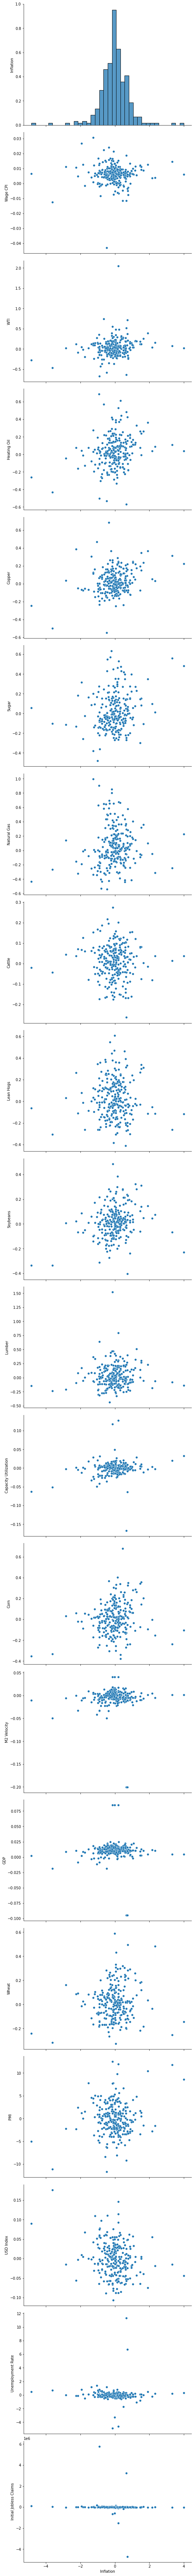

In [83]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Let's check this out on a histogram

Text(0, 0.5, 'Probability')

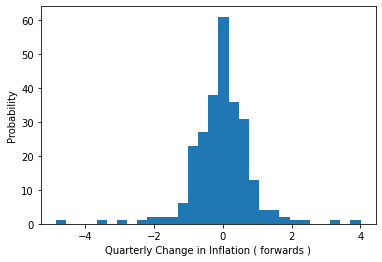

In [84]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

Noticeable outliers; let's check where they are.

In [85]:
cpi_outliers = np.abs(stats.zscore(QonQ_main_cpi_past['Inflation']))
threshold = 3
print(np.where(cpi_outliers >= threshold ))

(array([135, 154, 155, 161, 162], dtype=int64),)


In [86]:
QonQ_main_cpi_past['Inflation'][135],QonQ_main_cpi_past['Inflation'][154],QonQ_main_cpi_past['Inflation'][155],QonQ_main_cpi_past['Inflation'][161],QonQ_main_cpi_past['Inflation'][162]

(-2.84, -4.846, -3.625, 3.322, 4.007)

We will scrape all 5 representing 1.9% of the dataframe.

In [87]:
rows_to_drop = [135, 154, 155, 161, 162]
QonQ_main_cpi_past.drop(QonQ_main_cpi_past.index[rows_to_drop], inplace=True)

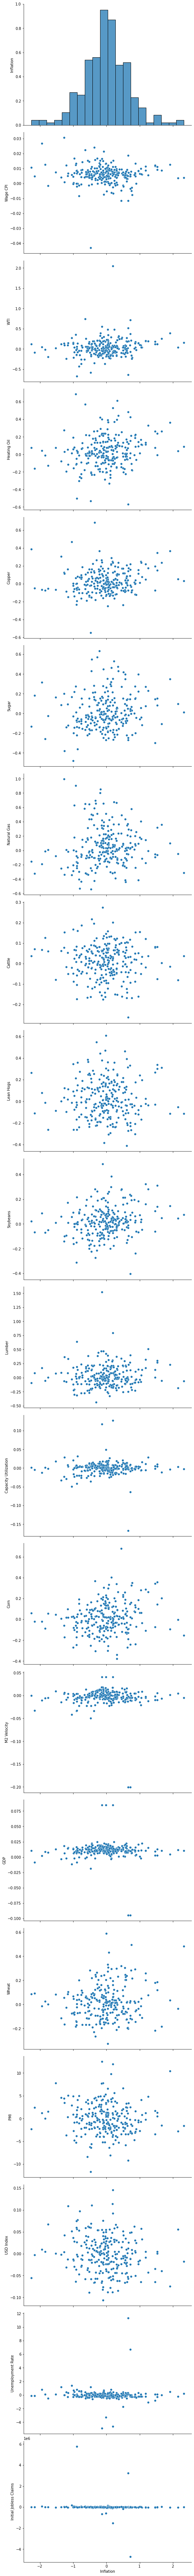

In [88]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

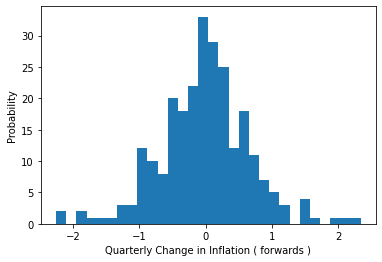

In [89]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

In [90]:
QonQ_main_cpi_past.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000 -0.078771  0.158390     0.180063  0.148539   
Wage CPI                -0.078771  1.000000  0.398407     0.491323  0.293190   
WTI                      0.158390  0.398407  1.000000     0.795155  0.407028   
Heating Oil              0.180063  0.491323  0.795155     1.000000  0.387828   
Copper                   0.148539  0.293190  0.407028     0.387828  1.000000   
Sugar                    0.132407  0.177799  0.183196     0.165222  0.225923   
Natural Gas              0.068245  0.308539  0.237982     0.405631  0.063657   
Cattle                  -0.070833  0.197031  0.150381     0.145592  0.108075   
Lean Hogs               -0.012605  0.105386  0.110716     0.071042  0.139915   
Soybeans                 0.204192  0.113954  0.117700     0.132189  0.174579   
Lumber                   0.047545  0.093830  0.269588     0.120588  0.198265   
Capacity Utilization     0.039181  0.226159  0.423595     0.347086  0.171318   
Corn                     0.171571  0.053884  0.002435     0.015135  0.077892   
M2 Velocity             -0.022216  0.288372  0.163000     0.217810  0.100942   
GDP                     -0.005916  0.272765  0.276807     0.231398  0.123840   
Wheat                    0.113172 -0.023828 -0.044497    -0.030833  0.059237   
PMI                     -0.075959  0.195649  0.384914     0.304015  0.408105   
USD Index               -0.141969 -0.264701 -0.237410    -0.272510 -0.293185   
Unemployment Rate        0.003111 -0.228021 -0.254273    -0.245137 -0.078806   
Initial Jobless Claims  -0.083912 -0.087210 -0.434324    -0.277920 -0.174785   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.132407     0.068245 -0.070833  -0.012605  0.204192   
Wage CPI                0.177799     0.308539  0.197031   0.105386  0.113954   
WTI                     0.183196     0.237982  0.150381   0.110716  0.117700   
Heating Oil             0.165222     0.405631  0.145592   0.071042  0.132189   
Copper                  0.225923     0.063657  0.108075   0.139915  0.174579   
Sugar                   1.000000     0.164111  0.025927  -0.067292  0.171362   
Natural Gas             0.164111     1.000000  0.007379   0.007984  0.029480   
Cattle                  0.025927     0.007379  1.000000   0.174839  0.083352   
Lean Hogs              -0.067292     0.007984  0.174839   1.000000  0.180694   
Soybeans                0.171362     0.029480  0.083352   0.180694  1.000000   
Lumber                  0.099663    -0.082385  0.195533   0.153378  0.173458   
Capacity Utilization    0.154558     0.093297  0.295119   0.146813  0.095273   
Corn                    0.109310     0.045301  0.023396   0.210120  0.691423   
M2 Velocity             0.103761     0.077690  0.200370   0.108432  0.013531   
GDP                     0.138388     0.089066  0.246119   0.142409  0.019672   
Wheat                   0.124825    -0.018829  0.003631  -0.001737  0.402931   
PMI                     0.088581     0.020433  0.183842   0.115218  0.136762   
USD Index              -0.128772    -0.217943 -0.035870   0.071310 -0.091914   
Unemployment Rate      -0.128179    -0.058842 -0.284562  -0.121200 -0.052114   
Initial Jobless Claims -0.132007    -0.052784 -0.175493  -0.051301 -0.054328   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.047545              0.039181  0.171571    -0.022216   
Wage CPI                0.093830              0.226159  0.053884     0.288372   
WTI                     0.269588              0.423595  0.002435     0.163000   
Heating Oil             0.120588              0.347086  0.015135     0.217810   
Copper                  0.198265              0.171318  0.077892     0.100942   
Sugar                   0.099663              0.154558  0.109310     0.103761   
Natural Gas            -0.082385              0.093297  0.045301     0.077690   
Cattle        

Looks fairly similar to a normal distribution; I will continue as such.

{'whiskers': [<matplotlib.lines.Line2D at 0x124f01b7640>,
 'caps': [<matplotlib.lines.Line2D at 0x124f01b7e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x124f01b73a0>],
 'medians': [<matplotlib.lines.Line2D at 0x124f01ed460>],
 'fliers': [<matplotlib.lines.Line2D at 0x124f01ed7c0>],
 'means': []}

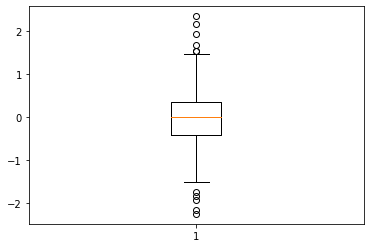

In [91]:
plt.boxplot(QonQ_main_cpi_past['Inflation'])

## 2.7.3 Quarterly Changes | Variables ( past ) & Inflation ( forwards ) | Pearson<a id='q_pf_pearson'></a>

Text(0.5, 1.0, 'Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

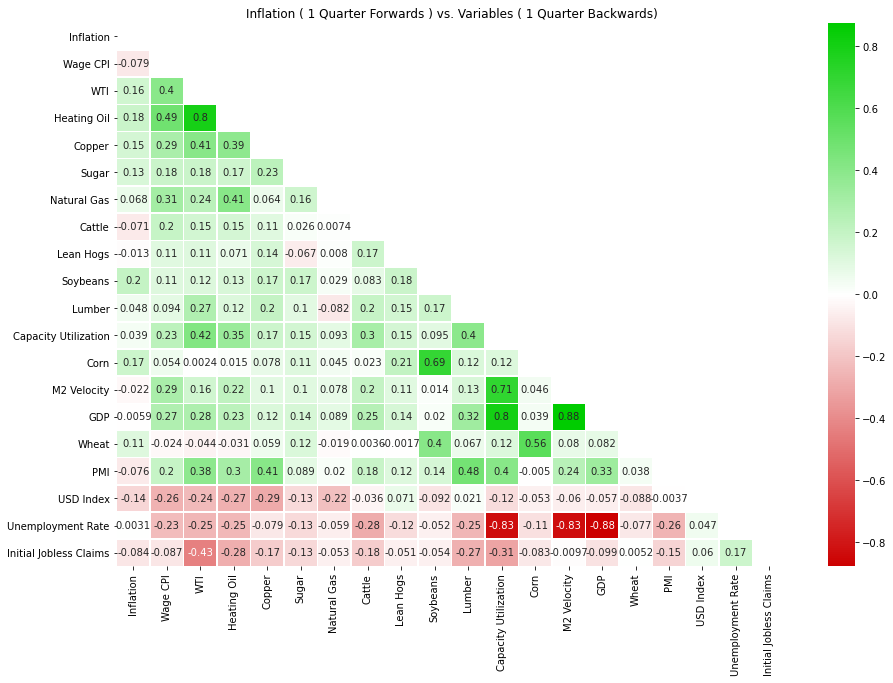

In [92]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_cpi_past.corr())
sns.heatmap(QonQ_main_cpi_past.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

In [170]:
# looking at the average pearson coefficient
q_q_pf = QonQ_main_cpi_past.corr(method='pearson')
q_q_pf = pd.DataFrame(q_q_pf['Inflation'])
q_q_pf = q_q_pf.iloc[1: , :]
q_q_pf['AbsAmount'] = q_q_pf['Inflation'].abs()
q_q_pf = q_q_pf['AbsAmount'].mean()


In [ ]:
QonQ_main_cpi_past = QonQ_main_cpi_past.sort_values(by="Date", ascending=True)
QonQ_main_cpi_past_csv = pd.DataFrame(QonQ_main_cpi_past)

QonQ_main_cpi_past_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main_cpi_past.xlsx')
print('Finished')

##  2.8 Q on Q Comparison w/ Rolling Averages on Daily, Wkly & Mnthly Variables ( w/ Inflation Scraping & no variable scraping )<a id='rolling'></a>

**This dataframe is being constructed a similar way 2.5 was created with the exception that the daily, weekly & monthly variables are taking a rolling average.** The rational with this interest is based on the idea that one of the variables would have had a bad day / week at the end of the term. If so, they may not properly display the impact they may have on inflation.

In [93]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_roll = Q_usd_index.rolling(66).mean()
Q_wti_roll = Q_wti.rolling(66).mean()

Q_copper_roll = Q_copper.rolling(66).mean()
Q_soybeans_roll = Q_soybeans.rolling(66).mean()
Q_natgas_roll = Q_natgas.rolling(66).mean()
Q_heatoil_roll = Q_heatoil.rolling(66).mean()
Q_corn_roll = Q_corn.rolling(66).mean()
Q_wheat_roll = Q_wheat.rolling(66).mean()
Q_cattle_roll = Q_cattle.rolling(66).mean()
Q_sugar_roll = Q_sugar.rolling(66).mean()
Q_lumber_roll = Q_lumber.rolling(66).mean()
Q_leanhogs_roll = Q_leanhogs.rolling(66).mean()

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll = Q_intjobs.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll = Q_caputil.rolling(3).mean()
Q_wages_roll = Q_wages.rolling(3).mean()
Q_unrate_roll = Q_unrate.rolling(3).mean()
Q_comppmi_roll =Q_comppmi.rolling(3).mean()

Q_cpi = cpi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

In [94]:
# Building out the variables first with a roll & forward fill
QonQ_vars_roll = pd.concat([Q_wages_roll,Q_wti_roll,Q_heatoil_roll,Q_copper_roll,Q_sugar_roll,
                            Q_natgas_roll,Q_cattle_roll,Q_leanhogs_roll,Q_soybeans_roll,Q_lumber_roll,
                            Q_caputil_roll,Q_corn_roll,Q_m2_velo,Q_gdp,Q_wheat_roll,Q_comppmi_roll,
                            Q_usd_index_roll,Q_unrate_roll,Q_intjobs_roll],
                      axis = 1, ignore_index=False)

QonQ_vars_roll.columns= ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'
                   ]

QonQ_vars_roll.index.names = ["Date"]
QonQ_vars_roll = QonQ_vars_roll.fillna(method='ffill')

# vars_mnth.tail()

In [95]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14240 entries, 1946-01-01 to 2021-07-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                14231 non-null  float64
 1   WTI                     12026 non-null  float64
 2   Heating Oil             13025 non-null  float64
 3   Copper                  10378 non-null  float64
 4   Sugar                   13025 non-null  float64
 5   Natural Gas             9853 non-null   float64
 6   Cattle                  13022 non-null  float64
 7   Lean Hogs               13027 non-null  float64
 8   Soybeans                9937 non-null   float64
 9   Lumber                  13027 non-null  float64
 10  Capacity Utilization    13971 non-null  float64
 11  Corn                    13024 non-null  float64
 12  M2 Velocity             14089 non-null  float64
 13  GDP                     14233 non-null  float64
 14  Wheat                

In [96]:
# As before, working backwards off of Natural Gas to bring the data together
# QonQ_vars_roll['Natural Gas'].tail(9565)

QonQ_vars_roll = QonQ_vars_roll.loc['1991-04-18':today_y_m_d_dash]

In [97]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9690 entries, 1991-04-18 to 2021-07-02
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                9690 non-null   float64
 1   WTI                     9690 non-null   float64
 2   Heating Oil             9690 non-null   float64
 3   Copper                  9690 non-null   float64
 4   Sugar                   9690 non-null   float64
 5   Natural Gas             9690 non-null   float64
 6   Cattle                  9690 non-null   float64
 7   Lean Hogs               9690 non-null   float64
 8   Soybeans                9690 non-null   float64
 9   Lumber                  9690 non-null   float64
 10  Capacity Utilization    9690 non-null   float64
 11  Corn                    9690 non-null   float64
 12  M2 Velocity             9690 non-null   float64
 13  GDP                     9690 non-null   float64
 14  Wheat                 

In [98]:
QonQ_vars_roll = QonQ_vars_roll.sort_values(by="Date", ascending=False)
QonQ_vars_roll_csv = pd.DataFrame(QonQ_vars_roll)

QonQ_vars_roll_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_roll_wout_CPImerge.xlsx')
print('Finished')

Finished


In [143]:
QonQ_vars_roll.describe()

Wage CPI          WTI  Heating Oil       Copper        Sugar  \
count  9633.000000  9633.000000  9633.000000  9633.000000  9633.000000   
mean      0.005515     0.025059     0.022288     0.020502     0.019346   
std       0.005687     0.152328     0.138047     0.119364     0.145402   
min      -0.034864    -0.539073    -0.462821    -0.505766    -0.393969   
25%       0.003931    -0.058506    -0.048390    -0.053042    -0.078617   
50%       0.006276     0.030677     0.020944     0.007002    -0.007340   
75%       0.008171     0.113630     0.107908     0.088883     0.102237   
max       0.023370     0.619696     0.388113     0.530210     0.610680   

       Natural Gas       Cattle    Lean Hogs     Soybeans       Lumber  \
count  9633.000000  9633.000000  9633.000000  9633.000000  9633.000000   
mean      0.034265     0.007620     0.019301     0.015109     0.033444   
std       0.194718     0.067185     0.141076     0.101082     0.160758   
min      -0.398806    -0.215529    -0.331947    -0.359508    -0.319931   
25%      -0.093312    -0.037546    -0.077745    -0.041762    -0.070579   
50%       0.008606     0.012942     0.009772     0.010881     0.020512   
75%       0.162135     0.055722     0.118976     0.069729     0.120631   
max       0.646182     0.256356     0.434222     0.293121     0.933175   

       Capacity Utilization         Corn  M2 Velocity          GDP  \
count           9633.000000  9633.000000  9633.000000  9633.000000   
mean              -0.000263     0.017545    -0.004147     0.010928   
std                0.017871     0.122730     0.022373     0.014104   
min               -0.128528    -0.340215    -0.200145    -0.094662   
25%               -0.004145    -0.052717    -0.007473     0.008557   
50%                0.001860     0.008063    -0.002745     0.011644   
75%                0.006573     0.080742     0.004618     0.015327   
max                0.096035     0.480516     0.040798     0.084535   

             Wheat          PMI    USD Index  Unemployment Rate  \
count  9633.000000  9633.000000  9633.000000        9633.000000   
mean      0.016814     0.181086     0.001533          -0.000055   
std       0.109139     3.007744     0.035262           0.872720   
min      -0.303035   -11.833333    -0.078002          -4.266667   
25%      -0.055196    -1.700000    -0.023525          -0.200000   
50%       0.008138     0.033333     0.001273          -0.100000   
75%       0.077483     1.866667     0.022650           0.066667   
max       0.444586    10.666667     0.120729           9.266667   

       Initial Jobless Claims  
count            9.633000e+03  
mean             3.088775e+03  
std              2.751182e+05  
min             -2.113167e+06  
25%             -1.141667e+04  
50%             -3.416667e+03  
75%              5.416667e+03  
max              3.105333e+06

In [99]:
# Putting them together with inflation
QonQ_main_roll = Q_cpi.merge(QonQ_vars_roll, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_main_roll = QonQ_main_roll.dropna()

In [100]:
QonQ_main_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 319 entries, 1991-04-30 to 2021-05-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               319 non-null    float64
 1   Wage CPI                319 non-null    float64
 2   WTI                     319 non-null    float64
 3   Heating Oil             319 non-null    float64
 4   Copper                  319 non-null    float64
 5   Sugar                   319 non-null    float64
 6   Natural Gas             319 non-null    float64
 7   Cattle                  319 non-null    float64
 8   Lean Hogs               319 non-null    float64
 9   Soybeans                319 non-null    float64
 10  Lumber                  319 non-null    float64
 11  Capacity Utilization    319 non-null    float64
 12  Corn                    319 non-null    float64
 13  M2 Velocity             319 non-null    float64
 14  GDP                    

## 2.8.2 Cleaning Q on Q Comparison w/ Rolling Averages<a id='rolling_clean'></a>

In [104]:
QonQ_main_roll.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.580766  0.538607     0.540992  0.367050   
Wage CPI                 0.580766  1.000000  0.715279     0.730877  0.517084   
WTI                      0.538607  0.715279  1.000000     0.907047  0.570403   
Heating Oil              0.540992  0.730877  0.907047     1.000000  0.548859   
Copper                   0.367050  0.517084  0.570403     0.548859  1.000000   
Sugar                    0.220492  0.233682  0.224088     0.264498  0.299160   
Natural Gas              0.288116  0.397185  0.337793     0.459573  0.167806   
Cattle                   0.162760  0.254538  0.178399     0.233267  0.127221   
Lean Hogs                0.266796  0.267868  0.316643     0.192968  0.206822   
Soybeans                 0.197638  0.252326  0.285774     0.257015  0.268255   
Lumber                   0.239507  0.224698  0.353868     0.238347  0.248686   
Capacity Utilization     0.341757  0.391907  0.491545     0.473397  0.333360   
Corn                     0.281067  0.233087  0.158899     0.150636  0.166088   
M2 Velocity              0.272488  0.330663  0.414156     0.380949  0.258159   
GDP                      0.322477  0.310712  0.473274     0.395983  0.255055   
Wheat                    0.122804  0.144061  0.048630     0.067479  0.154580   
PMI                      0.232612  0.337787  0.486258     0.387428  0.467200   
USD Index               -0.314049 -0.395094 -0.410198    -0.403891 -0.414914   
Unemployment Rate       -0.215523 -0.305630 -0.331620    -0.329478 -0.152750   
Initial Jobless Claims  -0.262230 -0.213557 -0.429609    -0.328241 -0.188918   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.220492     0.288116  0.162760   0.266796  0.197638   
Wage CPI                0.233682     0.397185  0.254538   0.267868  0.252326   
WTI                     0.224088     0.337793  0.178399   0.316643  0.285774   
Heating Oil             0.264498     0.459573  0.233267   0.192968  0.257015   
Copper                  0.299160     0.167806  0.127221   0.206822  0.268255   
Sugar                   1.000000     0.233294  0.099002  -0.114222  0.149179   
Natural Gas             0.233294     1.000000  0.141110   0.080464  0.097348   
Cattle                  0.099002     0.141110  1.000000   0.136164  0.083221   
Lean Hogs              -0.114222     0.080464  0.136164   1.000000  0.231489   
Soybeans                0.149179     0.097348  0.083221   0.231489  1.000000   
Lumber                  0.047987    -0.067985  0.259782   0.291191  0.233629   
Capacity Utilization    0.168838     0.252342  0.366242   0.173622  0.166699   
Corn                    0.100606     0.105494  0.075918   0.235541  0.728684   
M2 Velocity             0.126538     0.144705  0.266727   0.106283  0.061505   
GDP                     0.093263     0.139669  0.265645   0.147080  0.090026   
Wheat                   0.087292     0.034716  0.059238  -0.090936  0.458511   
PMI                     0.128484     0.052154  0.197929   0.165869  0.177601   
USD Index              -0.163008    -0.237472 -0.080598  -0.011877 -0.275766   
Unemployment Rate      -0.131705    -0.161916 -0.358783  -0.173553 -0.129011   
Initial Jobless Claims -0.124541    -0.126539 -0.259131  -0.098461 -0.100911   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.239507              0.341757  0.281067     0.272488   
Wage CPI                0.224698              0.391907  0.233087     0.330663   
WTI                     0.353868              0.491545  0.158899     0.414156   
Heating Oil             0.238347              0.473397  0.150636     0.380949   
Copper                  0.248686              0.333360  0.166088     0.258159   
Sugar                   0.047987              0.168838  0.100606     0.126538   
Natural Gas            -0.067985              0.252342  0.105494     0.144705   
Cattle        

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

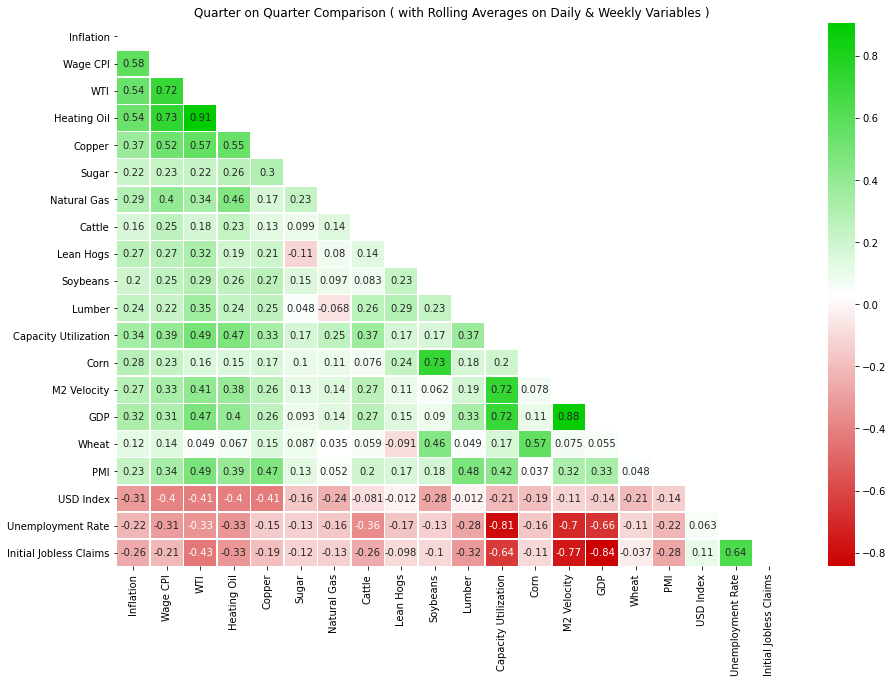

In [105]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

In [106]:
df = QonQ_main_roll.sort_values(by="Date", ascending=False)
df_csv = pd.DataFrame(QonQ_main_roll)

df_csv.to_csv('./_Capstone_One_Inflation/data/1.0_MAIN/inflation_df.csv')
print('finished')


finished


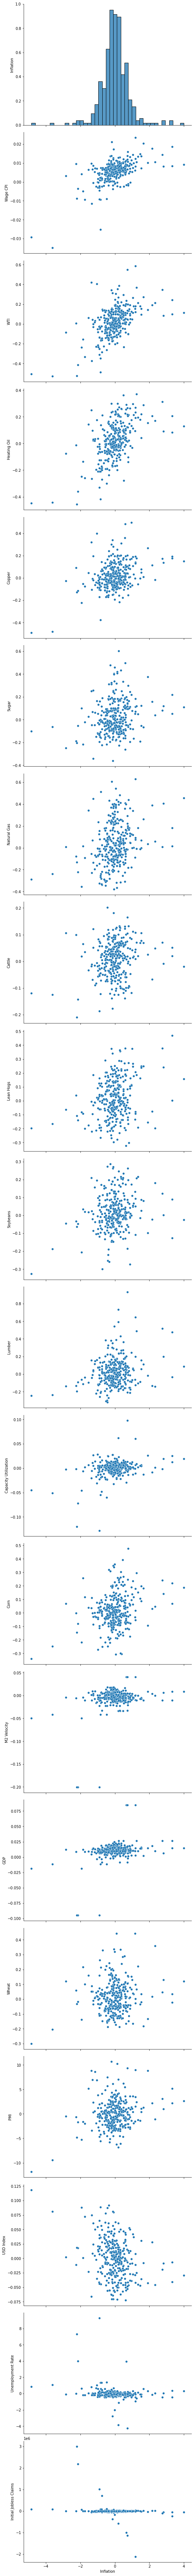

In [107]:
sns.pairplot(QonQ_main_roll,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars=['Inflation'],
            height=5, aspect=1.5,)

In [108]:
QonQ_main_roll = QonQ_main_roll.sort_values(by="Date", ascending=False)
QonQ_main_roll_csv = pd.DataFrame(QonQ_main_roll)

QonQ_main_roll_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_roll_wCPI_merge.xlsx')
print('Finished')

Finished


Text(0, 0.5, 'Probability')

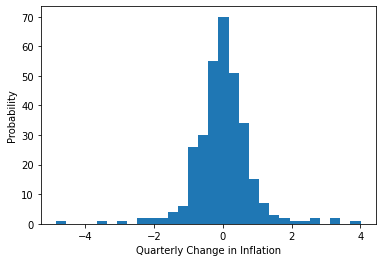

In [109]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

Given the Inflation data hasn't been changed since 1.31; we will scrape anything ± 300 bps

In [110]:
cpi_review = np.abs(stats.zscore(QonQ_main_roll['Inflation']))
threshold = 3
print( np.where( cpi_review > threshold ) )

(array([  0,   1, 128, 129, 130, 139, 140, 162], dtype=int64),)


In [111]:
QonQ_main_roll['Inflation'][156],QonQ_main_roll['Inflation'][178],QonQ_main_roll['Inflation'][179],QonQ_main_roll['Inflation'][188],QonQ_main_roll['Inflation'][189],QonQ_main_roll['Inflation'][190]

(0.2759999999999998,
 0.5409999999999999,
 -0.10799999999999965,
 0.3590000000000002,
 -0.1419999999999999,
 -0.11499999999999999)

Dropping those outside ±300 bps

In [112]:
droppingrows = [ 178, 179, 188, 189 ]
QonQ_main_roll.drop(QonQ_main_roll.index[droppingrows], inplace=True)

Text(0, 0.5, 'Probability')

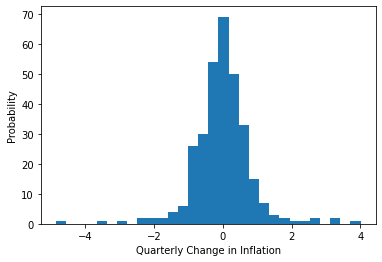

In [113]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Probability')

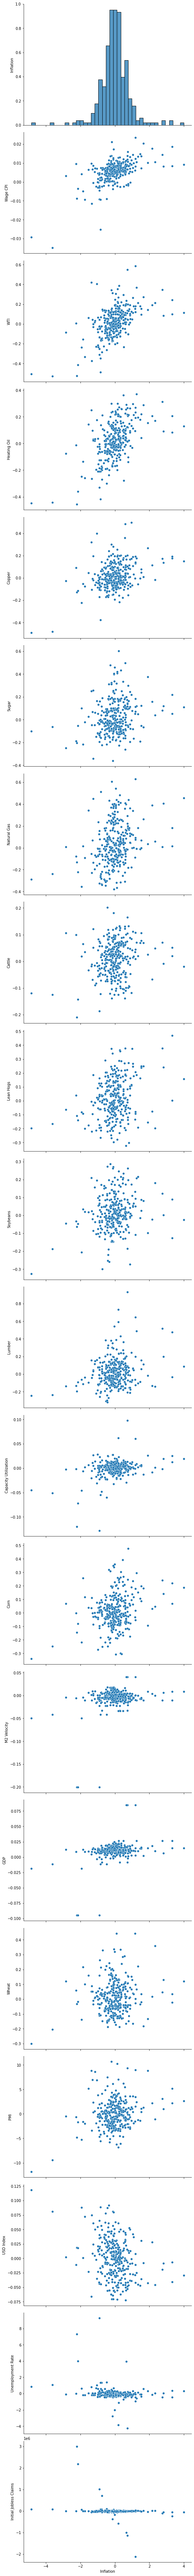

In [114]:
sns.pairplot(QonQ_main_roll,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

{'whiskers': [<matplotlib.lines.Line2D at 0x29fdfbe6190>,
 'caps': [<matplotlib.lines.Line2D at 0x29fdfbe6730>,
 'boxes': [<matplotlib.lines.Line2D at 0x29fded5a460>],
 'medians': [<matplotlib.lines.Line2D at 0x29fdfbe6df0>],
 'fliers': [<matplotlib.lines.Line2D at 0x29fdfbf4190>],
 'means': []}

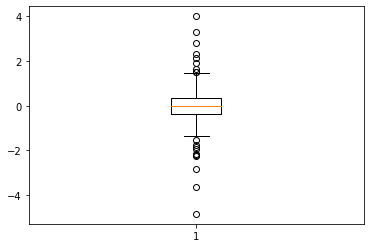

In [164]:
plt.boxplot(QonQ_main_roll['Inflation'])

## 2.8.3 Q on Q Comparison w/ Rolling Averages Pearson<a id='rolling_pearson'></a>

In [117]:
QonQ_main_roll.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.581040  0.538684     0.541482  0.372877   
Wage CPI                 0.581040  1.000000  0.714831     0.730624  0.520402   
WTI                      0.538684  0.714831  1.000000     0.907371  0.571286   
Heating Oil              0.541482  0.730624  0.907371     1.000000  0.554202   
Copper                   0.372877  0.520402  0.571286     0.554202  1.000000   
Sugar                    0.220877  0.234752  0.225880     0.265926  0.308857   
Natural Gas              0.289570  0.397384  0.338852     0.459777  0.170193   
Cattle                   0.166387  0.266482  0.192023     0.244300  0.168048   
Lean Hogs                0.267258  0.266047  0.314185     0.192155  0.193974   
Soybeans                 0.196889  0.249645  0.279565     0.255049  0.245745   
Lumber                   0.238894  0.222729  0.349912     0.236978  0.233457   
Capacity Utilization     0.341539  0.391618  0.490502     0.473250  0.333187   
Corn                     0.281808  0.230172  0.153040     0.147954  0.145608   
M2 Velocity              0.272918  0.330892  0.413902     0.380828  0.259640   
GDP                      0.322747  0.310789  0.473507     0.396539  0.256219   
Wheat                    0.122589  0.143790  0.047722     0.066668  0.156375   
PMI                      0.235212  0.337721  0.487775     0.387943  0.470830   
USD Index               -0.316170 -0.394475 -0.408977    -0.403198 -0.411733   
Unemployment Rate       -0.215555 -0.305563 -0.331634    -0.329437 -0.153867   
Initial Jobless Claims  -0.262389 -0.213599 -0.430327    -0.328468 -0.192155   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.220877     0.289570  0.166387   0.267258  0.196889   
Wage CPI                0.234752     0.397384  0.266482   0.266047  0.249645   
WTI                     0.225880     0.338852  0.192023   0.314185  0.279565   
Heating Oil             0.265926     0.459777  0.244300   0.192155  0.255049   
Copper                  0.308857     0.170193  0.168048   0.193974  0.245745   
Sugar                   1.000000     0.234113  0.097321  -0.113845  0.153632   
Natural Gas             0.234113     1.000000  0.147846   0.080284  0.099525   
Cattle                  0.097321     0.147846  1.000000   0.154489  0.109903   
Lean Hogs              -0.113845     0.080284  0.154489   1.000000  0.222925   
Soybeans                0.153632     0.099525  0.109903   0.222925  1.000000   
Lumber                  0.049906    -0.066418  0.281182   0.286400  0.218520   
Capacity Utilization    0.169787     0.254482  0.377304   0.172482  0.161313   
Corn                    0.103269     0.105516  0.099192   0.227284  0.725048   
M2 Velocity             0.127257     0.146293  0.273371   0.106585  0.057543   
GDP                     0.093418     0.141081  0.272151   0.146146  0.087169   
Wheat                   0.087731     0.034915  0.061302  -0.091161  0.462711   
PMI                     0.129506     0.050002  0.211018   0.163272  0.177943   
USD Index              -0.164836    -0.237582 -0.093909  -0.007287 -0.271212   
Unemployment Rate      -0.131950    -0.162331 -0.366344  -0.173763 -0.128738   
Initial Jobless Claims -0.124638    -0.126709 -0.264143  -0.098636 -0.101567   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.238894              0.341539  0.281808     0.272918   
Wage CPI                0.222729              0.391618  0.230172     0.330892   
WTI                     0.349912              0.490502  0.153040     0.413902   
Heating Oil             0.236978              0.473250  0.147954     0.380828   
Copper                  0.233457              0.333187  0.145608     0.259640   
Sugar                   0.049906              0.169787  0.103269     0.127257   
Natural Gas            -0.066418              0.254482  0.105516     0.146293   
Cattle        

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily, Weekly & Monthly Data )')

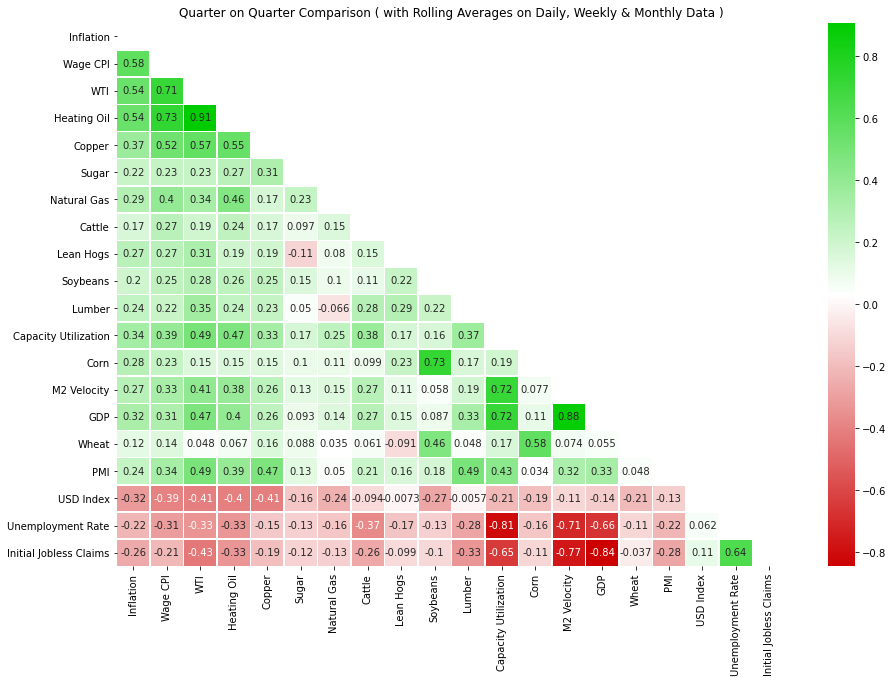

In [118]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily, Weekly & Monthly Data )')

In [171]:
# looking at the average pearson coefficient
q_q_roll = QonQ_main_roll.corr(method='pearson')
q_q_roll = pd.DataFrame(q_q_roll['Inflation'])
q_q_roll = q_q_roll.iloc[1: , :]
q_q_roll['AbsAmount'] = q_q_roll['Inflation'].abs()
q_q_roll_av = q_q_roll['AbsAmount'].mean()

In [119]:
QonQ_main_roll = QonQ_main_roll.sort_values(by="Date", ascending=False)
QonQ_main_roll_csv = pd.DataFrame(QonQ_main_roll)

QonQ_main_roll_csv.to_excel('./_Capstone_One_Inflation/data/1.0_Segmented_by_periods/QonQ_main_roll.xlsx')
print('Finished')

Finished


## 2.9 Project Summary<a id='p_summary'></a>

After review of various structures, I believe **the best Pearson Coefficient is with the Quarter on Quarter change with the rolling averages of the variables**. Let's take a look.

In [172]:
print('The Average Pearson coefficients below:','\n','\n',
     "{:,}%".format(round((q_q_main*100),2)),'| Quarter on Quarter','\n',
     "{:,}%".format(round((m_m_main*100),2)),'| Month on Month','\n',
     "{:,}%".format(round((q_q_pf*100),2)),' | Quarterly Changes | Variables ( past ) & Inflation ( forwards )','\n',
     "{:,}%".format(round((q_q_roll_av*100),2)),'| Quarter on Quarter with Rolling Averages','\n',)

The Average Pearson coefficients below: 
 
 21.06% | Quarter on Quarter 
 19.11% | Month on Month 
 9.26%  | Quarterly Changes | Variables ( past ) & Inflation ( forwards ) 
 30.45% | Quarter on Quarter with Rolling Averages 



**Confirmed.** Although those averages converted everything to a positive number, there were negative variables in some of the categories which aren't considered to be negatively correlated with Inflation. That said, all of the negative variables in the best performer are considered to be negatively correlated with Inflation; thus, **we will use this structure going forwards.**